
<center>
<h1>What is this all about?</h1>
<div>
We want to find a function $f$ that outputs :
</div>
<div>
$source\ code \rightarrow f(x) \rightarrow \{4, 120, 1, 4, 5, ...\}$
</div>    
</center>

# _Global

In [89]:
%load_ext tensorboard

In [ ]:
import os
import sys
import json
import pickle
from glob import glob
from itertools import permutations, product
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

import gym
import compiler_gym

import torch
from torch import nn
from torch.distributions import Categorical

import networkx as nx
import torch_geometric as pyg
import torch_geometric.nn as pygnn
import torch_geometric.transforms as T

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DATA_DIR = '/home/anthony/graph-data'

db = "https://dl.fbaipublicfiles.com/compiler_gym/state_transition_dataset/2021-11-15-csmith.tar.bz2"
db_sha256 = "0b101a17fdbb1851f38ca46cc089b0026eb740e4055a4fe06b4c899ca87256a2"

vocab_db = "https://dl.fbaipublicfiles.com/compiler_gym/state_transition_dataset/2021-11-15-vocab.tar.bz2"
vocab_db_sha256 = "https://dl.fbaipublicfiles.com/compiler_gym/state_transition_dataset/2021-11-15-vocab.tar.bz2"

with open('vocab.json') as fp:
    vocab = json.load(fp)
    

node_features = ['text', 'type']
edge_features = ['flow', 'position']

# utils
def get_graphs_by_scheme(scheme="benchmark://cbench-v1"):
    uris_ = env.datasets[scheme].benchmark_uris()
    graphs = []
    for uri in uris_:
        env.reset(uri)
        g = env.observation['Programl']
        graphs.append(g)
        
    return graphs

def parse_nodes(ns):
    a = []
    b = []
    for nid in ns:
        n = ns[nid]
        n.pop('function', None)
        n.pop('block', None)
        n.pop('features', None)
        n['text'] = vocab.get(n['text'], len(vocab))
        a.append(n['text'])
        b.append(n['type'])
    
    return np.array([a, b])

# features = [parse_nodes(i.nodes) for i in graphs]
# graphs = [nx.DiGraph(i) for i in graphs]

def to_pyg(g):
    g = pyg.utils.from_networkx(
        g, 
        group_node_attrs=node_features,
        group_edge_attrs=edge_features
    )
#     g.x = g.x.float()
#     g.edge_attr = g.edge_attr.float()
    return g

def save_graphs(graphs, uris):
    for i, j in zip(graphs, uris):
        nx.write_gexf(i, f"{DATA_DIR}/{s}.gexf")

def load_graphs():
    graphs = []
    ps = glob(f'{DATA_DIR}/*.gexf')
    print(f'loading {ps}')
    for p in ps:
        g = nx.read_gexf(p)
        graphs.append(g)
    
    return graphs

def save_pyg():
    for i, j in zip(pyg_graphs, data_ids):
        torch.save(i, f'{DATA_DIR}/{j}.pt')

def load_pyg():
    l = []
    for i in data_ids:
        t = torch.load(f'{DATA_DIR}/{i}.pt')
        l.append(t)
        
    return l

# Datasets

In [ ]:
env = compiler_gym.make(
    "llvm-ic-v0",
    benchmark="cbench-v1/qsort",
    reward_space="IrInstructionCountOz",
)

In [14]:
compiler_gym.COMPILER_GYM_ENVS

['gcc-v0',
 'llvm-v0',
 'llvm-ic-v0',
 'llvm-codesize-v0',
 'llvm-autophase-ic-v0',
 'llvm-autophase-codesize-v0',
 'llvm-ir-ic-v0',
 'llvm-ir-codesize-v0',
 'loop_tool-v0']

https://compilergym.com/llvm/index.html#datasets

In [9]:
example_datasets = ['cbench-v1', 'mibench-v1', 'blas-v0', 'anghabench-v1']
list(env.datasets)

[benchmark://cbench-v1,
 benchmark://anghabench-v1,
 benchmark://blas-v0,
 benchmark://chstone-v0,
 benchmark://clgen-v0,
 benchmark://github-v0,
 benchmark://linux-v0,
 benchmark://mibench-v1,
 benchmark://npb-v0,
 benchmark://opencv-v0,
 benchmark://poj104-v1,
 benchmark://tensorflow-v0,
 generator://csmith-v0,
 generator://llvm-stress-v0]

In [17]:
uris = list(env.datasets["benchmark://cbench-v1"].benchmark_uris())
data_ids = [j.split('//')[1].replace('/', '_') for j in uris]
uris

['benchmark://cbench-v1/adpcm',
 'benchmark://cbench-v1/bitcount',
 'benchmark://cbench-v1/blowfish',
 'benchmark://cbench-v1/bzip2',
 'benchmark://cbench-v1/crc32',
 'benchmark://cbench-v1/dijkstra',
 'benchmark://cbench-v1/ghostscript',
 'benchmark://cbench-v1/gsm',
 'benchmark://cbench-v1/ispell',
 'benchmark://cbench-v1/jpeg-c',
 'benchmark://cbench-v1/jpeg-d',
 'benchmark://cbench-v1/lame',
 'benchmark://cbench-v1/patricia',
 'benchmark://cbench-v1/qsort',
 'benchmark://cbench-v1/rijndael',
 'benchmark://cbench-v1/sha',
 'benchmark://cbench-v1/stringsearch',
 'benchmark://cbench-v1/stringsearch2',
 'benchmark://cbench-v1/susan',
 'benchmark://cbench-v1/tiff2bw',
 'benchmark://cbench-v1/tiff2rgba',
 'benchmark://cbench-v1/tiffdither',
 'benchmark://cbench-v1/tiffmedian']

In [20]:
env.reset()
env.render()

; ModuleID = '-'
source_filename = "-"
target datalayout = "e-m:e-p270:32:32-p271:32:32-p272:64:64-i64:64-f80:128-n8:16:32:64-S128"
target triple = "x86_64-unknown-linux-gnu"

%struct._IO_FILE = type { i32, i8*, i8*, i8*, i8*, i8*, i8*, i8*, i8*, i8*, i8*, i8*, %struct._IO_marker*, %struct._IO_FILE*, i32, i32, i64, i16, i8, [1 x i8], i8*, i64, %struct._IO_codecvt*, %struct._IO_wide_data*, %struct._IO_FILE*, i8*, i64, i32, [20 x i8] }
%struct._IO_marker = type opaque
%struct._IO_codecvt = type opaque
%struct._IO_wide_data = type opaque
%struct.my3DVertexStruct = type { i32, i32, i32, double }

@stderr = external dso_local global %struct._IO_FILE*, align 8
@.str = private unnamed_addr constant [27 x i8] c"Usage: qsort_large <file>\0A\00", align 1
@.str.1 = private unnamed_addr constant [2 x i8] c"r\00", align 1
@.str.2 = private unnamed_addr constant [3 x i8] c"%d\00", align 1
@.str.3 = private unnamed_addr constant [57 x i8] c"\0ASorting %d vectors based on distance from the origin.\0A\

In [22]:
# takes too long

# for i in env.datasets.benchmarks():
#     obs = env.reset(benchmark=i)
#     print(sys.getsizeof(pickle.dumps(obs)))

# Simple description of compiler

<table>
  <tr>
    <th>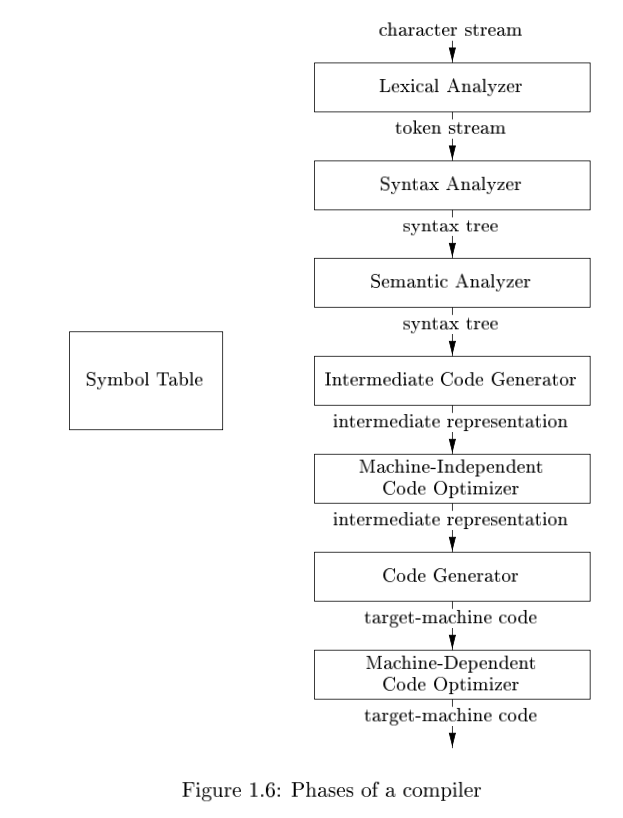</th>
    <th>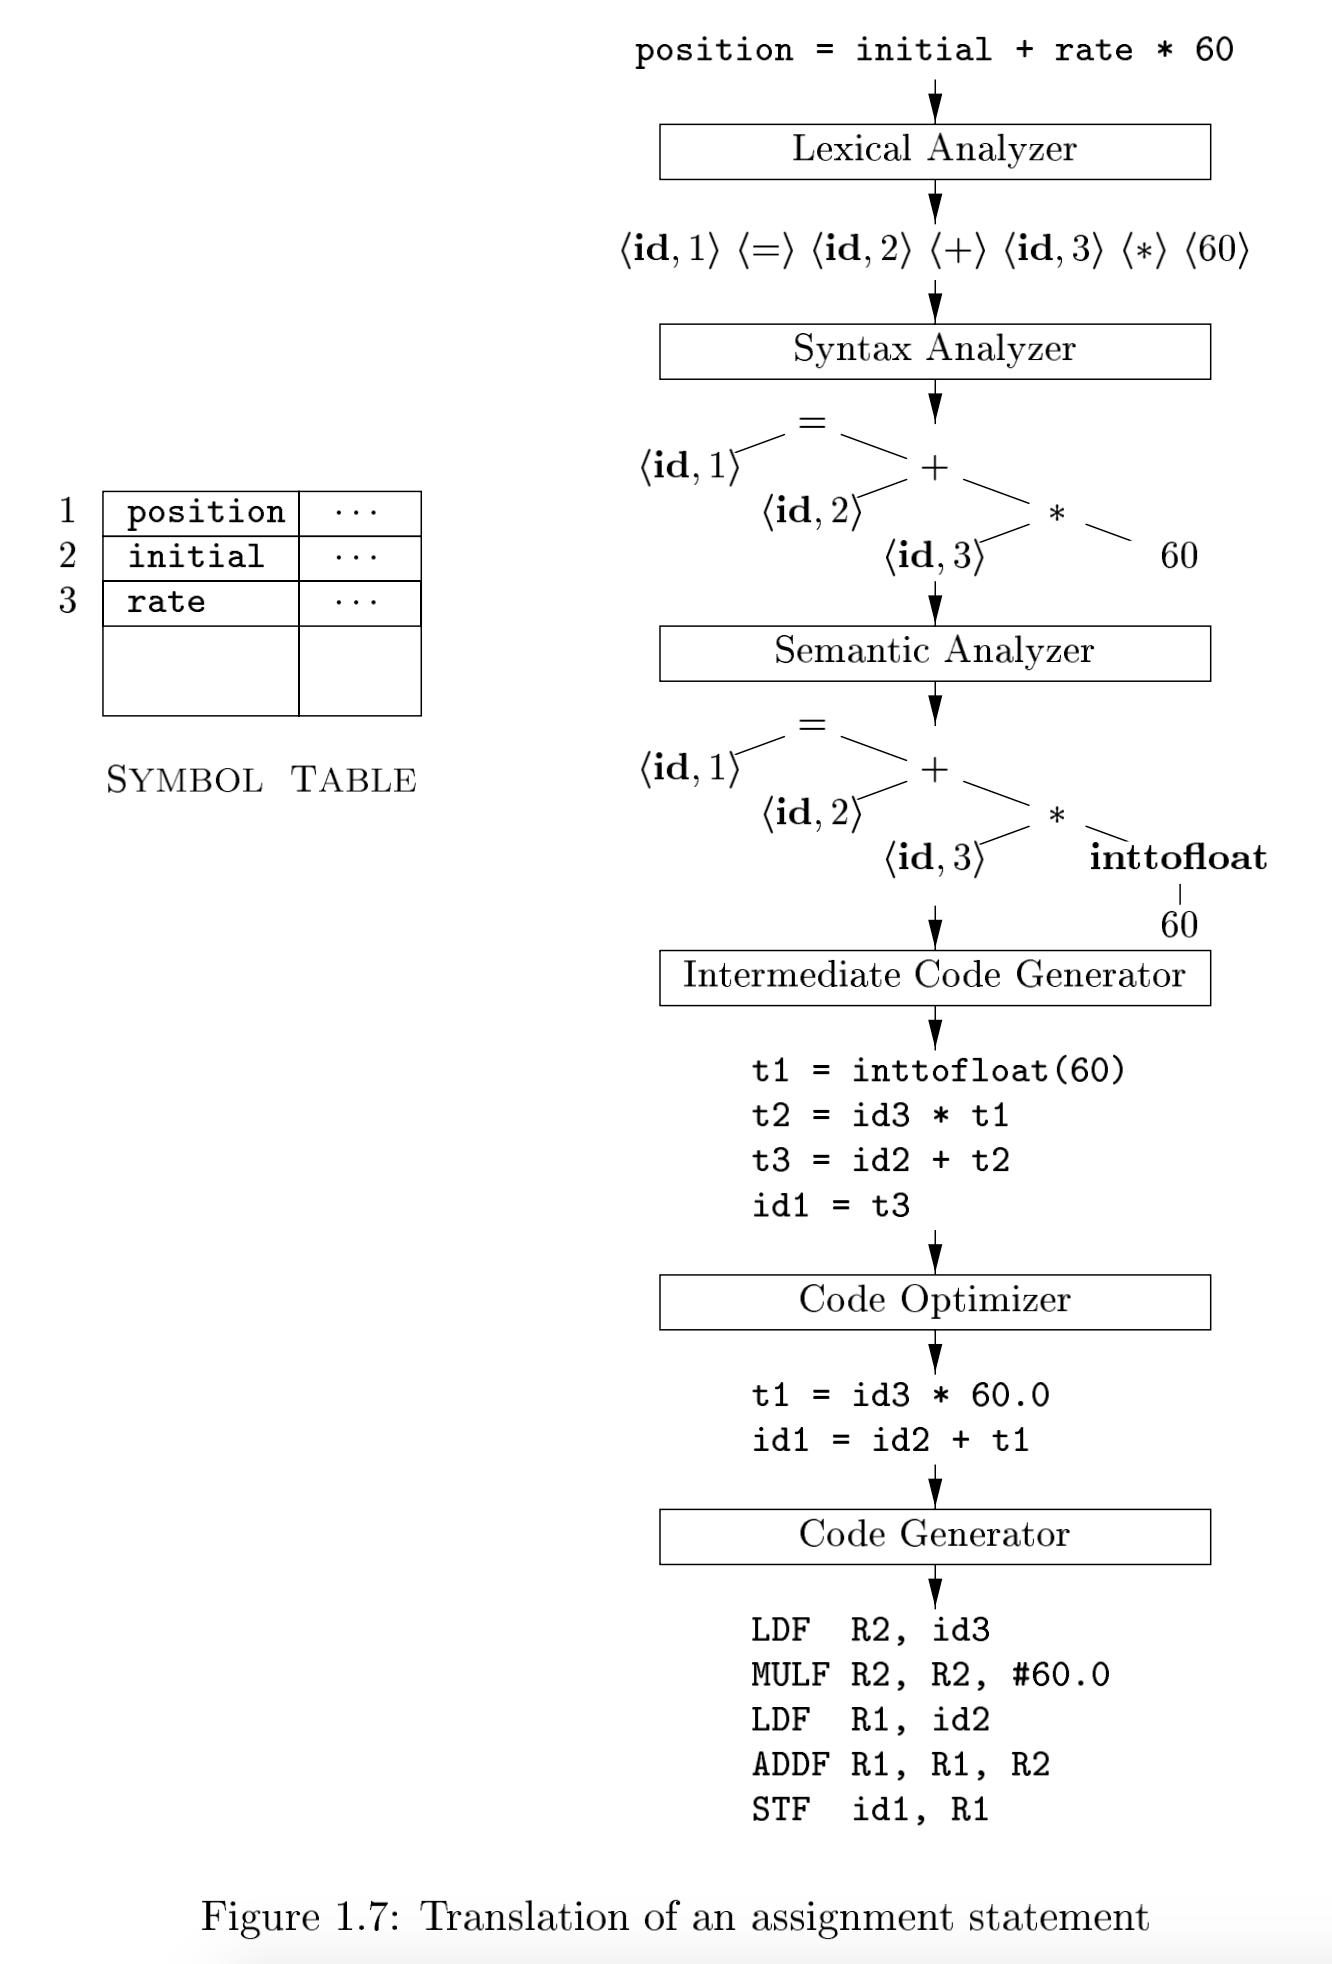</th>
  </tr>
</table>

ref : dragon book

from now on, we'll stick with the 3-phase abstraction from LLVM

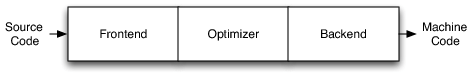

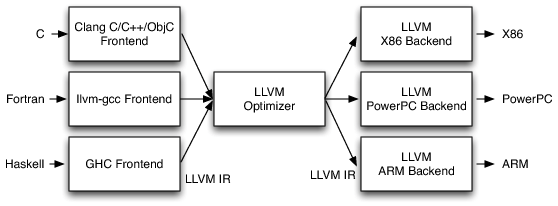

http://www.aosabook.org/en/llvm.html

[TODO] what if we use AST from semantic analyzer instead of IR?

# Objective

Adaptively(to source code) find sequence of actions(compiler options), that reduces a program's code size, running time. 

i.e. reduce space & time complexity of code, relative to compiled code without options

<div>
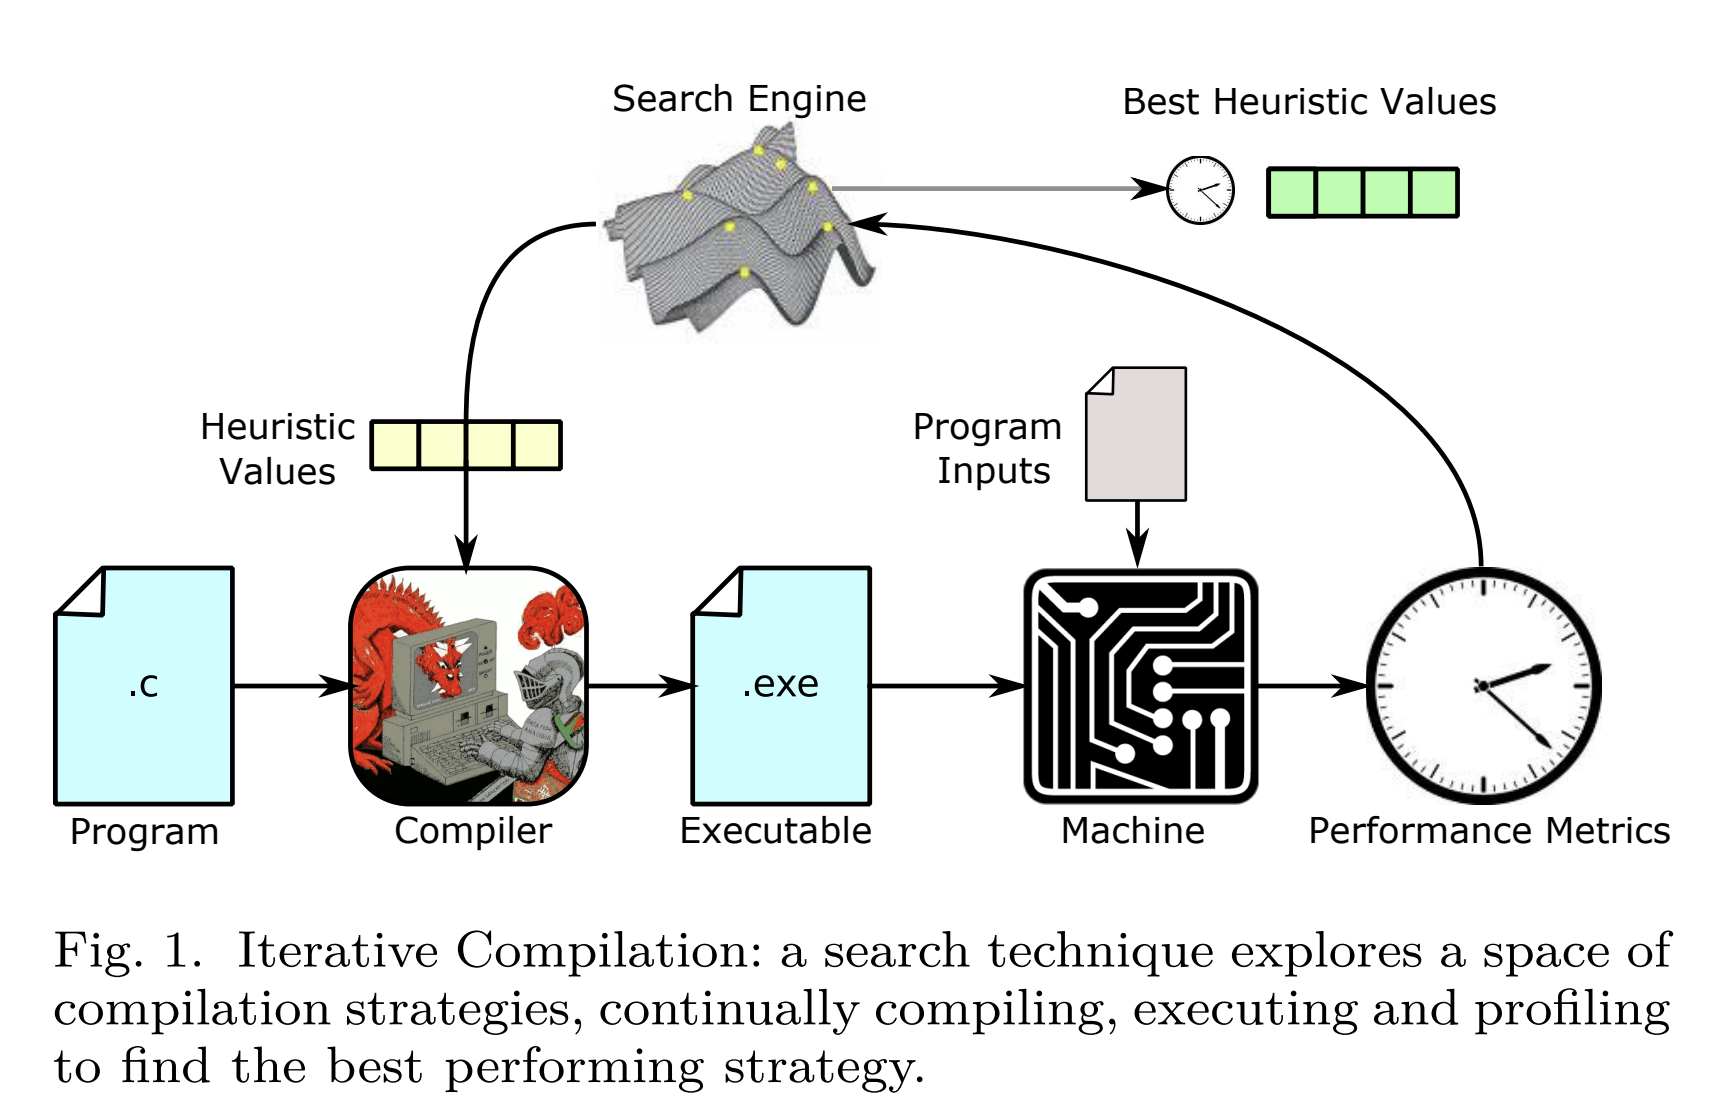
</div>

# RL formulation

Why? -> extremely large search space, the decision process is completely markov, 

Using domain knowledge, I think search space can be drastically reduced by discarding redundant actions

Some actions won't affect a thing, duplicate action won't affect a thing

<div>
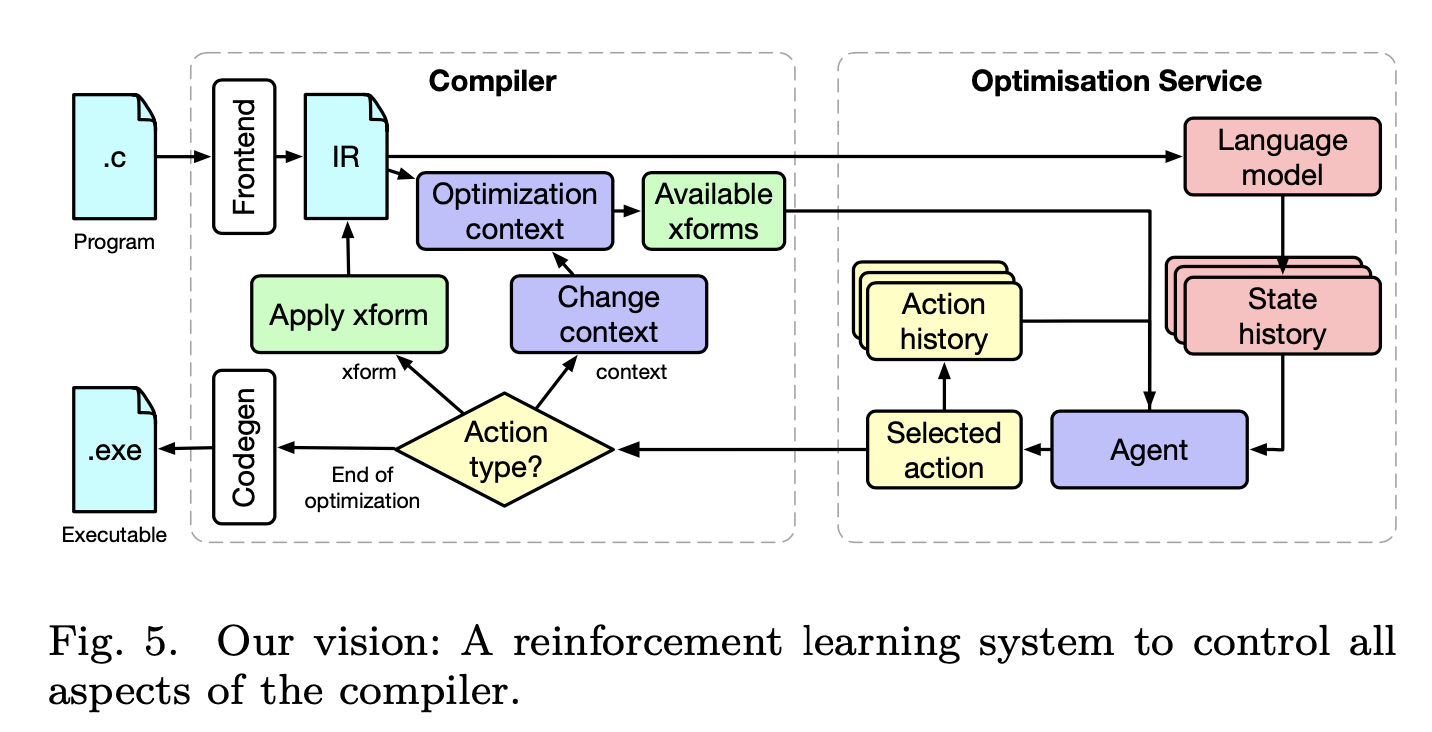
</div>

Partially optimized program provides the state, and an action is to select a single optimization pass to run. 

The selected pass is then run, producing a new state. 

Reward is provided by compiling the partially optimized program and estimating the execution cycle count.

https://chriscummins.cc/pub/2020-fdl.pdf

**Possible Actions**
https://gcc.gnu.org/onlinedocs/gcc/Option-Summary.html

[TODO] 
check duplicate action -> doesn't seem to have effect.
then search space is roughly reduced $|Options|^k \rightarrow |Options|!$ where $k<\infty$

Among various tasks, we're interested in 'LLVM Phase Ordering'

> A. LLVM Phase Ordering 
>> LLVM [11] is a modular compiler infrastructure used
throughout academia and industry. After parsing an input source
program to a language-agnostic Intermediate Representation
(IR), the LLVM optimizer applies a configurable pipeline of
optimization passes to the IR. The selection and ordering of
compiler optimizations – known as phase ordering – greatly
impacts the quality of the final binary and has been the focus
of much research [1], [12].
We include a phase ordering environment in CompilerGym
as an example of a challenging, high-dimensional optimization
problem in which significant gains can be achieved.


https://arxiv.org/pdf/2109.08267.pdf

## Combinatorial Optimization

We may formulate phase ordering as combinatorial optimization problem

> Combinatorial optimization is a subfield of mathematical optimization that consists of finding an optimal object from a **finite set** of objects, where the **set of feasible solutions** is discrete or can be reduced to a discrete set.

---
let set of options $A$,

first reduce  $|A|^{\infty}\rightarrow|A|^{k}$ by constraining option sequence length to some number $k\in \mathbb N$(which is to be determined by domain knowledge?). 

If k goes to infinity, the solution is infeasible(infinite sequence of options)

and we find subset(probably sequence) $S\subseteq A$ which minimizes cost function $J$

---

[TODO] RL <-> CO

## Action Space

discrete action space

`Commandline` is inherited from `gym.spaces.Discrete`

In [14]:
env.action_space

Commandline([-add-discriminators -adce -aggressive-instcombine -alignment-from-assumptions -always-inline -argpromotion -attributor -barrier -bdce -break-crit-edges -simplifycfg -callsite-splitting -called-value-propagation -canonicalize-aliases -consthoist -constmerge -constprop -coro-cleanup -coro-early -coro-elide -coro-split -correlated-propagation -cross-dso-cfi -deadargelim -dce -die -dse -reg2mem -div-rem-pairs -early-cse-memssa -early-cse -elim-avail-extern -ee-instrument -flattencfg -float2int -forceattrs -inline -insert-gcov-profiling -gvn-hoist -gvn -globaldce -globalopt -globalsplit -guard-widening -hotcoldsplit -ipconstprop -ipsccp -indvars -irce -infer-address-spaces -inferattrs -inject-tli-mappings -instsimplify -instcombine -instnamer -jump-threading -lcssa -licm -libcalls-shrinkwrap -load-store-vectorizer -loop-data-prefetch -loop-deletion -loop-distribute -loop-fusion -loop-guard-widening -loop-idiom -loop-instsimplify -loop-interchange -loop-load-elim -loop-predicati

In [ ]:
which exact part does option ~~~

>Actions: The action space consists of a discrete choice from
**124 optimization passes** extracted automatically from LLVM.
There is **no maximal episode length** as episodes can run forever
(except in the case of a compiler bug leading to an error), the
**user must estimate** when no further gains can be achieved and
no further actions should be taken. For any particular program
the optimal phase ordering **may omit or repeat actions.**


* Adding terminal action such as `-END`, we expect the model to learn when to end it's episode, 
  
  interpreting the model is outputing meaningful actions with shorter episode

* [TODO] can we reduce action space while running the episode?


In [53]:
def _p(*s):
    for i in s:
        print(i, '\n')

In [129]:
env.reset()

In [130]:
ac = env.action_space.from_string('-reg2mem')
ac

27

In [131]:
env.state

CompilerEnvState(benchmark='benchmark://cbench-v1/qsort', commandline='opt  input.bc -o output.bc', walltime=2.7181296348571777, reward=0.0)

In [133]:
_p(env.step(ac), env.state)

(None, -0.018575851393188854, False, {'action_had_no_effect': False, 'new_action_space': False}) 

benchmark='benchmark://cbench-v1/qsort' commandline='opt -reg2mem -reg2mem input.bc -o output.bc' walltime=72.86436867713928 reward=-0.16408668730650153 



In [134]:
ac = env.action_space.from_string('-instcombine')
ac

53

In [136]:
_p(env.step(ac), env.state)

(None, 0.0, False, {'action_had_no_effect': True, 'new_action_space': False}) 

benchmark='benchmark://cbench-v1/qsort' commandline='opt -reg2mem -reg2mem -instcombine -instcombine input.bc -o output.bc' walltime=98.74476027488708 reward=0.012383900928792602 



In [153]:
l = []
for i in range(env.action_space.n):
    d = {}
    env.reset()
    for j in range(10):
        _, _, _, info = env.step(i)
        d[env.action_space.names[i] + f'{j}'] = info['action_had_no_effect']
    l.append(d)

In [155]:
for i in l:
    j = list(i.values())
    if j[-1] == False:
        print(i)

{'-reg2mem0': False, '-reg2mem1': False, '-reg2mem2': False, '-reg2mem3': False, '-reg2mem4': False, '-reg2mem5': False, '-reg2mem6': False, '-reg2mem7': False, '-reg2mem8': False, '-reg2mem9': False}
{'-ipsccp0': False, '-ipsccp1': False, '-ipsccp2': False, '-ipsccp3': False, '-ipsccp4': False, '-ipsccp5': False, '-ipsccp6': False, '-ipsccp7': False, '-ipsccp8': False, '-ipsccp9': False}
{'-instnamer0': False, '-instnamer1': False, '-instnamer2': False, '-instnamer3': False, '-instnamer4': False, '-instnamer5': False, '-instnamer6': False, '-instnamer7': False, '-instnamer8': False, '-instnamer9': False}
{'-newgvn0': False, '-newgvn1': False, '-newgvn2': False, '-newgvn3': False, '-newgvn4': False, '-newgvn5': False, '-newgvn6': False, '-newgvn7': False, '-newgvn8': False, '-newgvn9': False}
{'-reassociate0': False, '-reassociate1': False, '-reassociate2': False, '-reassociate3': False, '-reassociate4': False, '-reassociate5': False, '-reassociate6': False, '-reassociate7': False, '-r

In [124]:
l = []
env.reset()
for _ in range(10):
    for i in range(env.action_space.n):
        _, _, _, info = env.step(i)
        l.append(not info['action_had_no_effect'])

In [125]:
env.action_space.n

124

oh my god

In [126]:
np.array(l).sum()

337

# !SHOW SHELL!

## Reward

In [15]:
env.reward_range

(-inf, inf)

>Rewards: We support optimizing for three metrics: **code
size**, which is the number of instructions in the IR; **binary
size**, which is the size of the .text section in the compiled
object file; and **runtime**, which is the wall time of the compiled
program when run using a specific configuration of inputs
on the machine hosting the CompilerGym backend. When
used as a reward signal each metric returns the change in
value between the previous environment state and the new
environment state. Each reward signal **can optionally be scaled**
against the gains achieved by the compiler’s default phase
orderings, -Oz for size reduction and -O3 for runtime. Code
size is **platform-independent and determinsitic**, binary size
is **platform-dependent and deterministic**, and **runtime is both
platform-specific and nondeterministic.**

Currently, FAIR's focusing on code size, because the lesser instructions to execute, the faster

https://compilergym.com/llvm/index.html#reward-spaces

What if we directly optimize to runtime reward instead of proxy(code size) reward?

## Observation
some of available representations

In [81]:
env.reset()
env.observation.Inst2vec()
# env.inst2vec.embeddings -> difference?

Failed to stop session 3 with ServiceIsClosed: Service is offline


array([[-0.59749085,  0.63315004, -0.0308373 , ...,  0.14833118,
         0.86420786,  0.44808227],
       [-0.59749085,  0.63315004, -0.0308373 , ...,  0.14833118,
         0.86420786,  0.44808227],
       [-0.59749085,  0.63315004, -0.0308373 , ...,  0.14833118,
         0.86420786,  0.44808227],
       ...,
       [-0.59749085,  0.63315004, -0.0308373 , ...,  0.14833118,
         0.86420786,  0.44808227],
       [-0.8005934 ,  1.066408  , -0.94866973, ...,  0.65057874,
         0.07959317,  0.25205553],
       [-0.43074277,  0.8589559 , -0.35770646, ...,  0.28785184,
         0.8492773 ,  0.8914213 ]], dtype=float32)

In [17]:
env.inst2vec.vocab

{'<@ID> = internal global { i8 } zeroinitializer, align 1': 0,
 '<@ID> = global i32 <INT>, align 4': 1,
 '<@ID> = private unnamed_addr constant [42 x i8]  <STRING>, align 1': 2,
 '<@ID> = private unnamed_addr constant [12 x i8]  <STRING>, align 1': 3,
 '<@ID> = private unnamed_addr constant [68 x i8]  <STRING>, align 1': 4,
 '<@ID> = private unnamed_addr constant [2 x i8]  <STRING>, align 1': 5,
 '<@ID> = private unnamed_addr constant [17 x i8]  <STRING>, align 1': 6,
 '<@ID> = private unnamed_addr constant [1 x i8] zeroinitializer, align 1': 7,
 '<@ID> = private unnamed_addr constant [4 x i8]  <STRING>, align 1': 8,
 '<@ID> = private unnamed_addr constant [21 x i8]  <STRING>, align 1': 9,
 '<@ID> = private unnamed_addr constant [24 x i8]  <STRING>, align 1': 10,
 '<@ID> = private unnamed_addr constant [32 x i8]  <STRING>, align 1': 11,
 '<@ID> = private unnamed_addr constant [20 x i8]  <STRING>, align 1': 12,
 '<@ID> = private unnamed_addr constant [29 x i8]  <STRING>, align 1': 13,
 

In [18]:
vocab_size = len(env.inst2vec.vocab)
vocab_size

8565

In [19]:
env.inst2vec.unknown_vocab_element

8564

In [82]:
a = env.inst2vec.preprocess('add')
b = env.inst2vec.encode(a)
c = env.inst2vec.embed(b)
c

array([[-0.59749085,  0.63315004, -0.0308373 ,  0.7813929 ,  0.2824597 ,
        -1.0372775 ,  0.36418545,  0.15349057,  0.09020552, -0.4659993 ,
        -0.35997885,  0.6558393 ,  0.49994135,  0.1397922 , -0.6336526 ,
         0.31698313, -0.12916723,  0.3801932 ,  0.4985292 , -0.67801744,
        -0.3576161 , -0.6201355 , -0.2688608 , -0.6429077 , -0.28733674,
         0.45257568,  0.42162472,  0.563448  ,  0.8472564 ,  0.5020532 ,
        -0.5930469 ,  0.6329507 , -0.6270224 ,  0.8504921 ,  1.1572483 ,
        -0.61934423,  0.04846289,  0.6872113 ,  0.40980676,  0.71378785,
        -0.6609579 , -0.59899014, -0.7408138 , -0.18388142, -0.7327102 ,
         0.6023345 ,  0.02391127,  0.07967863,  0.38212216,  0.10762829,
        -1.1090298 , -0.68528455,  0.14418058, -0.8773999 , -0.68944144,
        -0.74505293, -0.9791414 , -0.37118408,  0.804273  , -0.7226868 ,
         0.21153025,  0.48133445, -0.92416567, -0.40870827, -0.98301125,
         0.30009332, -0.36340907, -0.04214132, -0.4

https://compilergym.com/llvm/index.html#autophase

In [102]:
env.observation.Autophase()

array([  0,   4,  54,  39,  12,  46,  23,   6,  12,  31,   2,   4,   0,
        81,   4,  77,  13,  15, 108, 106,  75,  51,  71,  46,  15,   0,
         9,  46,   0,  13,  72,  51,  77,  81,  39,  31,   0, 163,   2,
         0,   4,   6,  13,   1,   0,  73,   8,   1,   0,  15,  85, 638,
       402,  16,  10, 298])

**Previous Works**
* code2vec - AST path; trained representation put more weight on names rather than code structure. use cases : smart pasting, auto-refactoring
* Neural Code Comprehension - uses parital data- and control- flow; loses info such as order of instruction operands. Contextual Flow Graph(XFG) built from LLVM-IR
* (recent)LLVM-IR - Control and Data Flow(CDFG); control and data relation btw instructions are explicit, but uses only instruction opcodes

### ProGraML
(Program Graph for Machine Learning)

https://arxiv.org/pdf/2003.10536.pdf
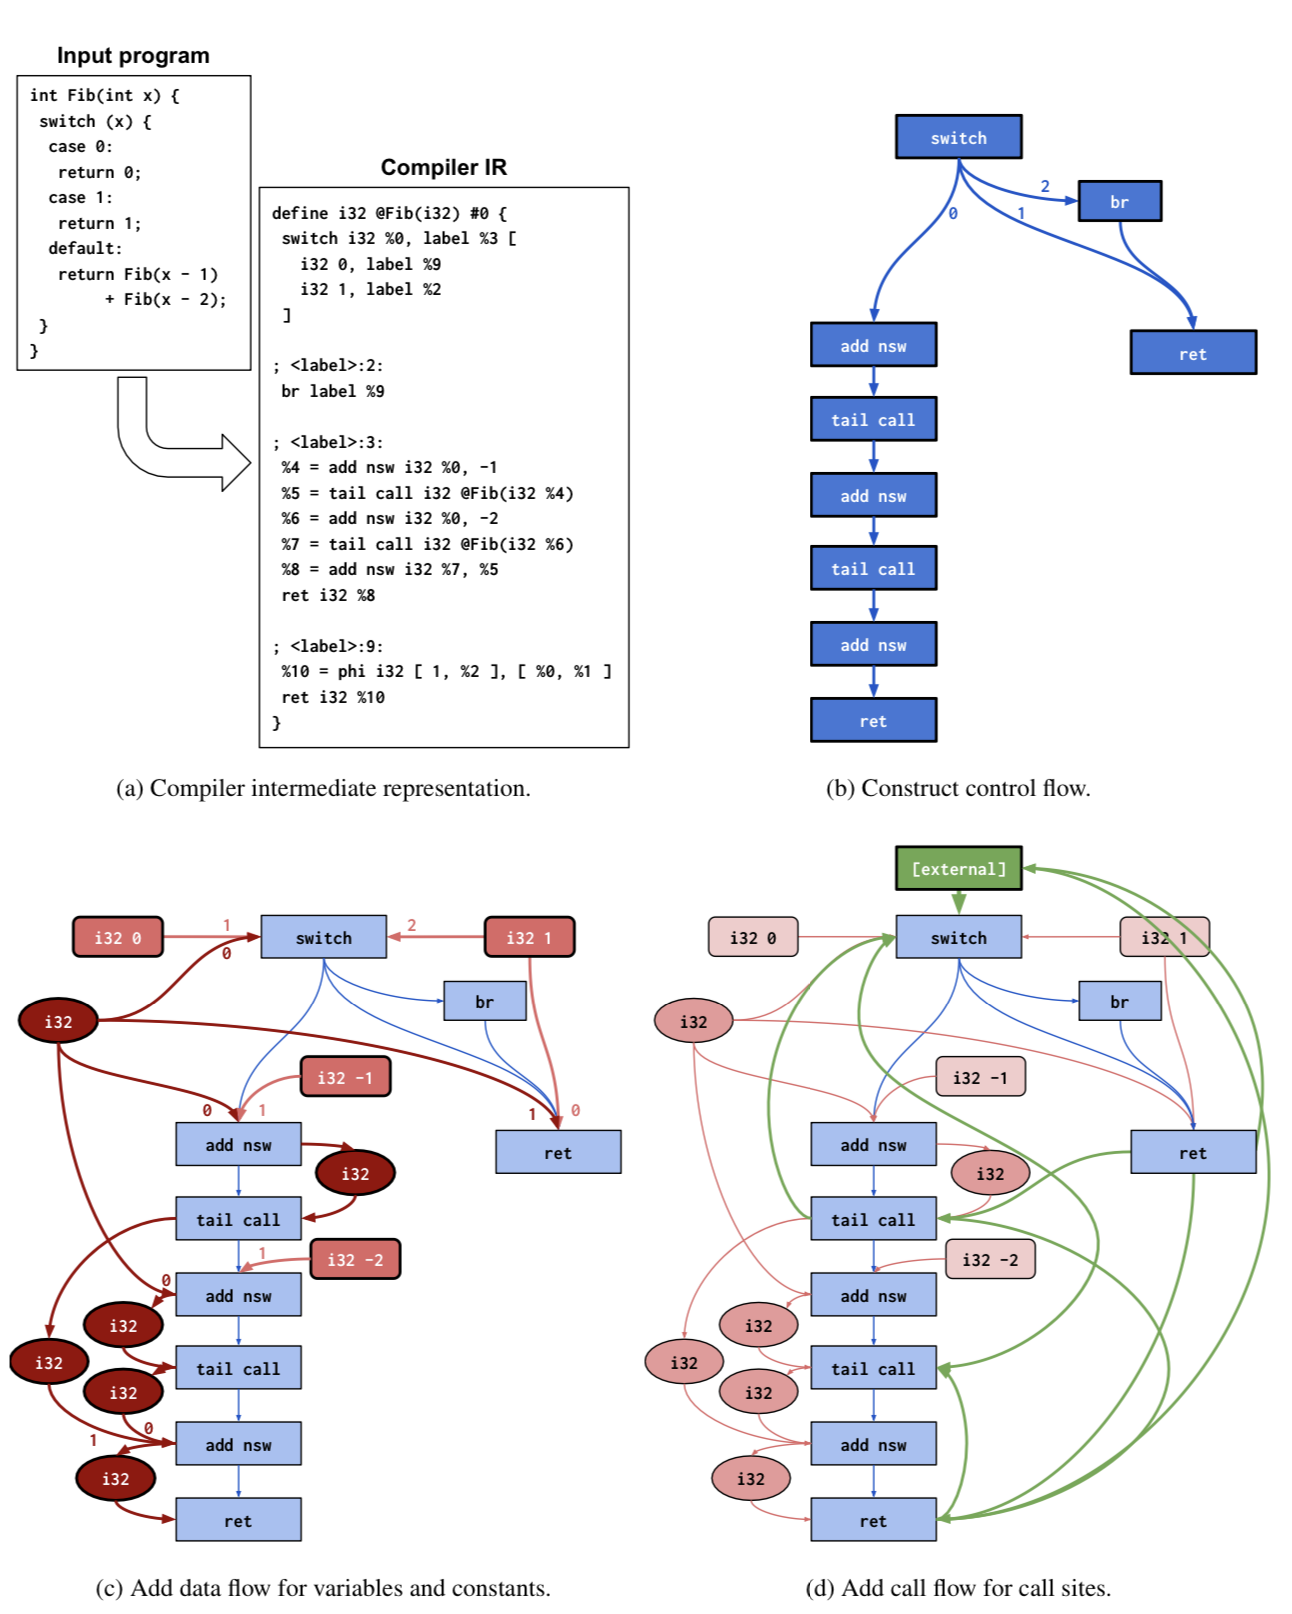

<!-- ![PNG%20image.png](attachment:PNG%20image.png) -->
**Node Features**

https://chriscummins.cc/ProGraML/api/protocol-buffers.html#features

<img src="attachment:PNG%20image.png" width="800"/>

heterogeneous directied graph $G^i=(V^i, E^i), i\in \{control , data, call\}$

graph construction : 3 stages(control-, data-, call- flow)

**control flow graph(CFG)**

$V = \{instructions\}$

$E = \{control\,flow\,edges\}$

$e \in E$ has position labels, $0 \leq e_{pos} \leq n$

**data flow graph(DFG)**

$V = \{constant\,values\,and\,variables\}$

$E = \{data\,flow\,edges\}$

$e \in E$ has position labels, $0 \leq e_{pos} \leq n$

**call graph(CG)**

$V = \{dummy\}$

$E = \{call\,edges\}$

control edges don't span functions(talking about functions in program)

IR with functions $F$ produces $|F|$ disconnected subgraphs

call edges has no position labels

**Computational Cost**

https://arxiv.org/pdf/2109.08267.pdf

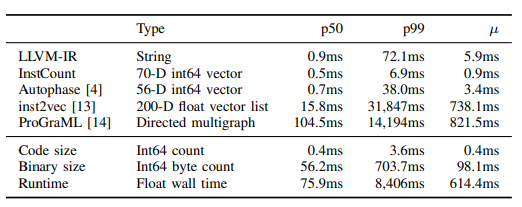

In [26]:
# plt.figure(figsize=(18,18))
# g = env.observation.Programl()
# nc = list(nx.get_node_attributes(g, 'type').values())
# nx.draw_kamada_kawai(g, node_color=nc)
# plt.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 442


In [26]:
def collect_attr(vals, key):
    l = []
    for i in vals:
        l.append(vals[i][key])

    return l

In [27]:
def get_block(bid: int):
    l = []
    for i in obs.nodes:
        n = obs.nodes[i]
        if n['block'] == bid:
            l.append(n)
    return l

In [ ]:
obs.is_multigraph()

True

In [30]:
obs.is_directed()

True

In [31]:
obs.nodes[0]

{'block': 0, 'function': 0, 'text': '[external]', 'type': 0}

In [32]:
obs.nodes[100]

{'block': 13,
 'features': {'full_text': ['i32 %40']},
 'function': 3,
 'text': 'i32',
 'type': 1}

In [33]:
l = collect_attr(obs.nodes, 'function')
np.unique(l, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
 array([ 137,    1,    1,  153,    1,    1,    1,    1,    1,  197,    1,
           1,    1,    1,    1,   96,    1,  213,  143,    1,   11,    1,
        1439,    1,  509,  431,  536,    1, 1535,  293, 3349, 6110,    1,
        1980,  272, 5949,    1, 5297,  815,   10,   12,    1,    1,  103,
           1]))

In [34]:
l = collect_attr(obs.nodes, 'type')
np.unique(l, return_counts=True)
# instruction, variable, constant

(array([0, 1, 2]), array([13305, 16186,   121]))

In [35]:
get_block(20)

[{'block': 20,
  'features': {'full_text': ['%62 = bitcast [10000 x i8]* %6 to i8*']},
  'function': 3,
  'text': 'bitcast',
  'type': 0},
 {'block': 20,
  'features': {'full_text': ['[10000 x i8]* %6']},
  'function': 3,
  'text': '[10000 x i8]*',
  'type': 1},
 {'block': 20,
  'features': {'full_text': ['call void @llvm.lifetime.end.p0i8(i64 10000, i8* %62) #7']},
  'function': 3,
  'text': 'call',
  'type': 0},
 {'block': 20,
  'features': {'full_text': ['i8* %62']},
  'function': 3,
  'text': 'i8*',
  'type': 1},
 {'block': 20,
  'features': {'full_text': ['%63 = bitcast i32* %5 to i8*']},
  'function': 3,
  'text': 'bitcast',
  'type': 0},
 {'block': 20,
  'features': {'full_text': ['i32* %5']},
  'function': 3,
  'text': 'i32*',
  'type': 1},
 {'block': 20,
  'features': {'full_text': ['call void @llvm.lifetime.end.p0i8(i64 4, i8* %63) #7']},
  'function': 3,
  'text': 'call',
  'type': 0},
 {'block': 20,
  'features': {'full_text': ['i8* %63']},
  'function': 3,
  'text': 'i8*',

In [36]:
get_block(42)

[{'block': 42,
  'features': {'full_text': ['%56 = load i32, i32* %9, align 4, !tbaa !4']},
  'function': 17,
  'text': 'load',
  'type': 0},
 {'block': 42,
  'features': {'full_text': ['i32* %9']},
  'function': 17,
  'text': 'i32*',
  'type': 1},
 {'block': 42,
  'features': {'full_text': ['%57 = load i32, i32* %8, align 4, !tbaa !4']},
  'function': 17,
  'text': 'load',
  'type': 0},
 {'block': 42,
  'features': {'full_text': ['i32* %8']},
  'function': 17,
  'text': 'i32*',
  'type': 1},
 {'block': 42,
  'features': {'full_text': ['%58 = sub nsw i32 %57, %56']},
  'function': 17,
  'text': 'sub',
  'type': 0},
 {'block': 42,
  'features': {'full_text': ['i32 %57']},
  'function': 17,
  'text': 'i32',
  'type': 1},
 {'block': 42,
  'features': {'full_text': ['i32 %56']},
  'function': 17,
  'text': 'i32',
  'type': 1},
 {'block': 42,
  'features': {'full_text': ['store i32 %58, i32* %8, align 4, !tbaa !4']},
  'function': 17,
  'text': 'store',
  'type': 0},
 {'block': 42,
  'featu

In [37]:
obs.edges[list(obs.edges)[0]]

{'flow': 2, 'position': 0}

In [38]:
obs.edges[list(obs.edges)[100]]

{'flow': 2, 'position': 0}

# !SHOW GEPHI EXAMPLE!

In [39]:
# edges are indentical? 
edge_attrs = list(map(obs.edges.get, obs.edges))
for i in edge_attrs:
    assert {'flow', 'position'} == i.keys()
    
# edges have same type, 0?
for i in obs.edges:
    assert i[2] == 0

In [40]:
l = collect_attr(obs.edges, 'flow')
np.unique(l, return_counts=True)
# control flow, data flow, call flow

(array([0, 1, 2]), array([13581, 34842,   956]))

In [41]:
l = collect_attr(obs.edges, 'position')
np.unique(l, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  8, 10, 12, 14, 16, 18, 20]),
 array([43530,  5622,   164,    30,    12,     8,     6,     1,     1,
            1,     1,     1,     1,     1]))

## Encoding

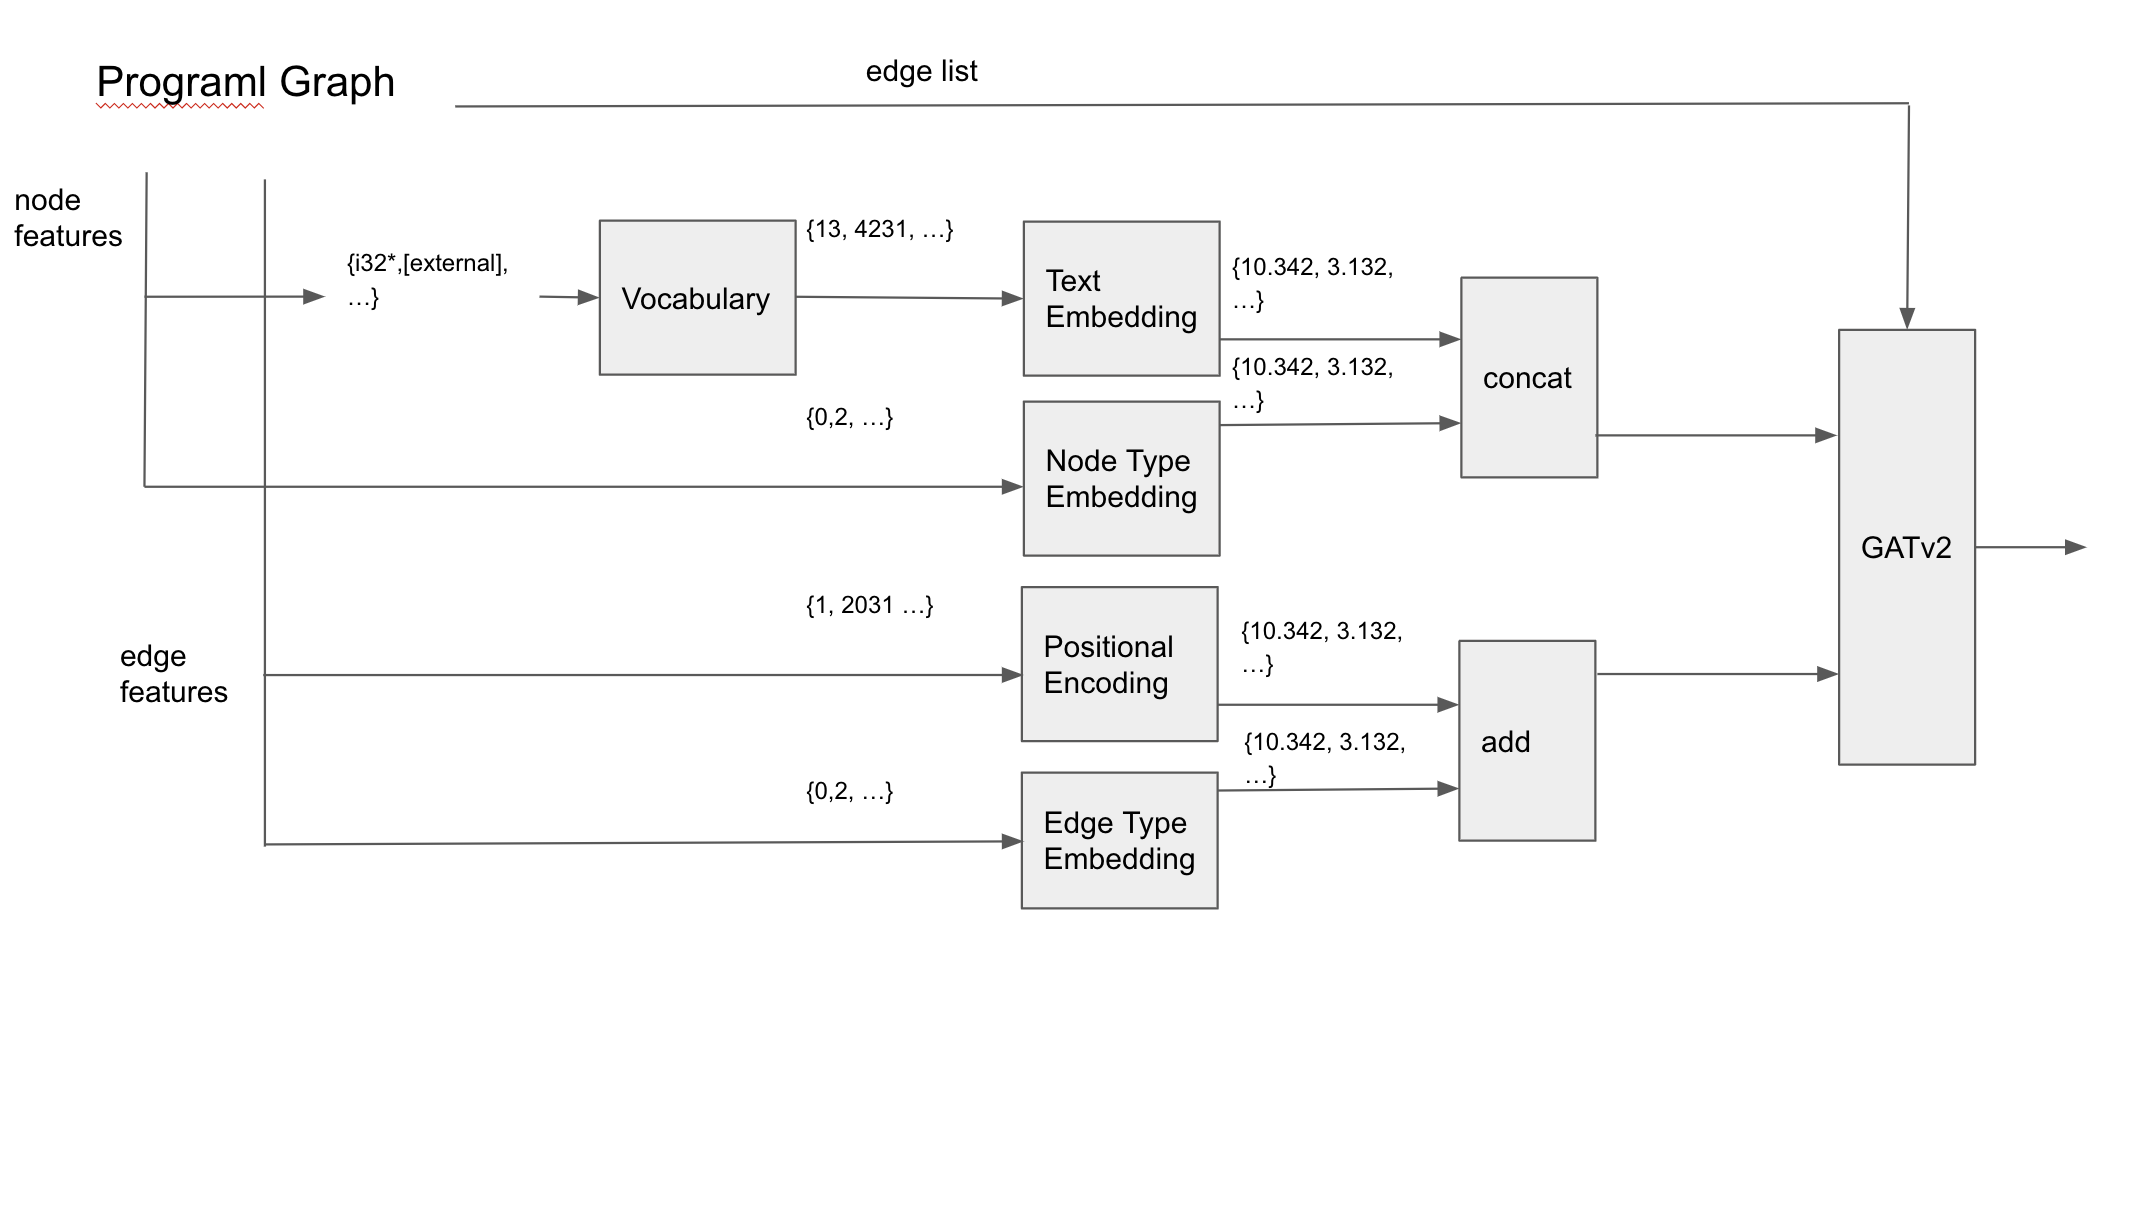

Transform heterogeous graph to homogeneous graph by embedding node, edge types as categorical features

### Node Features

text $\{\textbf h^{text}_i, i\in V\}$ : 

Use vocabulary dictionary to transform tokens to numerics. I didn't face much OOVs(out of vocab.)

type $\{\textbf h^{type}_i, i\in V\}$ : 

Categorical embedding

node feature $\textbf h_i = \{\textbf h^{type}_i || \textbf h^{type}_i\}$


### Edges Features

position $\{\textbf e^{position}_i, i\in E\}$: 

Use positional encoding(from Transformer) for ordinal & unique expression. Add a linear layer to make it trainable. 

Around 5000~ positions can cover most of the datasets

type $\{\textbf e^{type}_i, i\in E\}$: 

Categorical embedding

node feature $\textbf e_i = \{\textbf e^{position}_i + \textbf e^{type}_i\}$


In [5]:
vocab

{'void (%"type 0x7f67317b1ef0"*, i64)*': 0,
 '[34 x %"type 0x7efe38050be0"]*': 1,
 'i32 (%struct.gx_device_s.643*, i8*, i32, i32, i64, i64*, %struct.gx_strip_bitmap_s*, i64*, i32, i32, i32, i32, i32, i32, i32)*': 2,
 '[7 x %"type 0x7f5128ab4610"]*': 3,
 'i32 (%"type 0x7f656c01ffd0"*, i32, %"type 0x7f656c018b40"*)*': 4,
 'i8* (%struct.jpeg_common_struct.687*, i64)*': 5,
 'void (%"type 0x7f8b309213e0"*, %"type 0x7f8b03f4a1c0"*)*': 6,
 'void (%"type 0x7f442c05d3a0"*)**': 7,
 'void (%"type 0x7f0d1d64f060"*)**': 8,
 'i32 (%"type 0x7f8b03f08030"*, i8***)*': 9,
 'void (%"type 0x7fd220058900"*, i32)**': 10,
 'i32 (%"type 0x7f6fd4c844d0"*)**': 11,
 'i64 (%"type 0x7f0d1c03d010"*)*': 12,
 '[10 x void (%"type 0x7f38f0020000"*, %"type 0x7f38f00c6020"*, i16*, i8**, i32)*]*': 13,
 '[60000 x %"type 0x7effd8197b20"]*': 14,
 'i32 (%struct.gx_device_vector_s.6673*)*': 15,
 '[2 x [513 x float]]*': 16,
 'void (%struct.jpeg_common_struct.687*, %struct.backing_store_struct*, i8*, i64, i64)*': 17,
 'i32 (%"ty

<table>
  <tr>
    <th>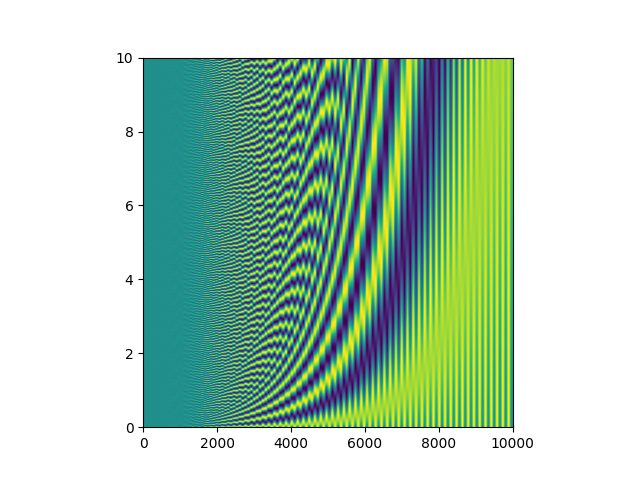positional encoding</th>
    <th>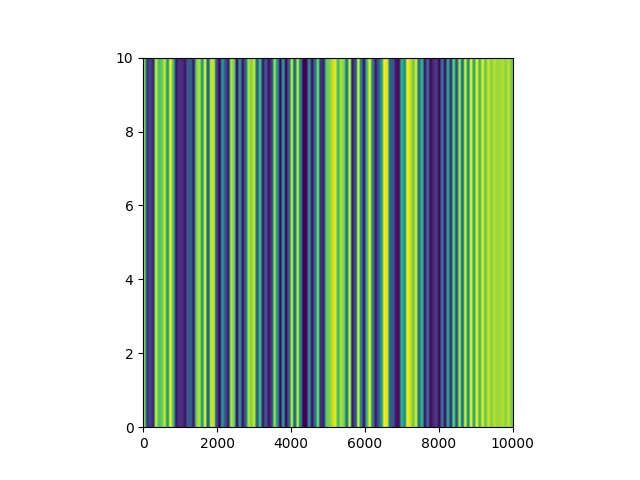encoded</th>
  </tr>
</table>


### Future Works

**Analyze the attention**

Observe the nodes with high attention

**TDA**

Assuming Programl is effective representation of program, analyze topological property of the graph, rather than searching through euclidean space where graph is sparsely embedded in.

Naively, Programl is a very low-level representation of code, so there's not much that we can consider node/edge feature, only structures and orders 

Maybe GNN(with large enough capacity) will learn the topology itself, but need proper justification


**Action Generation**

Difficult

**Use AST**

hyperbolic embedding

**Use walltime as reward**

figure out why they stick to code size

**Use walltime as reward**

figure out why they stick to code size

## Model

Using the output features from the encoder above, do policy gradient

# Experiments

let set of problem instances $Q$ 

each problem indexed as $Q_i, i\in \{0,...,k\}$, where $k$ is the problem set size


we train a function $f$

I tried 3 experimental setups

1. train $f_i$ for each $Q_i$

2. train a single $f_0$ for $\forall Q_i$ in synchronous(sequential) manner

3. train a single $f_0$ for $\forall Q_i$ in asynchronous manner with distributed computing


~~I tried 3 versions of PPO~~
~~1. from scratch~~
~~2. rllib~~
~~3. some PPO impl. from github~~

In [137]:
%tensorboard --logdir /data1/anthony/ray_result

In [96]:
import pandas as pd
from scipy import stats

In [87]:
df = pd.read_csv('/home/anthony/logs/compiler_gym/mlarchsys-competition-2022/2022-05-26/07-50-40/results.csv')

In [88]:
df

,benchmark,reward,walltime,commandline
0,benchmark://mlarchsys2022/70f5116f5db9ec31d740...,0.531539,146.789656,opt -sroa -jump-threading -early-cse-memssa -j...
1,benchmark://mlarchsys2022/9210e6f83b1aec1516dd...,0.727400,694.159965,opt -sroa -early-cse-memssa -sroa -sroa -const...
2,benchmark://mlarchsys2022/8e132265f0e6a96da7de...,0.775568,3059.292857,opt -sroa -early-cse-memssa -sroa -sroa -sroa ...
3,benchmark://mlarchsys2022/2e018994a4ba94be85a7...,0.635643,227.917041,opt -early-cse-memssa -sroa -early-cse-memssa ...
4,benchmark://mlarchsys2022/12869e1093bc4e1f3f67...,0.384325,124.271273,opt -sroa -sroa -simplifycfg -strip-dead-proto...
5,benchmark://mlarchsys2022/ba1c894bbe85e8da2f9d...,0.652634,264.135112,opt -early-cse-memssa -sroa -early-cse-memssa ...
6,benchmark://mlarchsys2022/6ef050ff4b567989bfa7...,0.645497,496.175180,opt -sroa -sroa -instcombine -early-cse-memssa...
7,benchmark://mlarchsys2022/d3f156f8b774ba4ef7c0...,0.605024,256.110344,opt -sroa -sroa -sroa -sroa -instcombine -load...
8,benchmark://mlarchsys2022/6c14524e23d09e9e4d73...,0.513706,886.657991,opt -sroa -sroa -sroa -sroa -early-cse-memssa ...
9,benchmark://mlarchsys2022/70f7a924d4d49223f63b...,0.850642,30656.282125,opt -sroa -early-cse-memssa -sroa -sroa -early...


In [97]:
stats.gmean(df.reward)

0.6208039007183301

In [99]:
df.walltime.mean()

1814.331557393074

In [148]:
for j, i in zip(data_ids, gg):
    s = ''
    if len(i.x) > int(1e5) or len(i.edge_attr) > int(1e5):
        s = '*'
    elif len(i.x) > int(1e6) or len(i.edge_attr) > int(1e6):
        s = '**'
    print(s, j, len(i.x), len(i.edge_attr))

* cbench-v1_adpcm 127169 223991
 cbench-v1_bitcount 1739 3058
* cbench-v1_blowfish 102545 181693
* cbench-v1_bzip2 121387 213709
 cbench-v1_crc32 1351 2380
 cbench-v1_dijkstra 8684 14976
* cbench-v1_ghostscript 122152 215010
 cbench-v1_gsm 1826 3146
 cbench-v1_ispell 1184 2105
* cbench-v1_jpeg-c 121855 214554
* cbench-v1_jpeg-d 123729 221954
 cbench-v1_lame 891 1593
 cbench-v1_patricia 2700 4831
 cbench-v1_qsort 512 907
* cbench-v1_rijndael 128909 231283
 cbench-v1_sha 2630 4772
 cbench-v1_stringsearch 31206 54381
* cbench-v1_stringsearch2 59412 105845
* cbench-v1_susan 831232 1501132
 cbench-v1_tiff2bw 981 1823
 cbench-v1_tiff2rgba 29664 53754
 cbench-v1_tiffdither 29612 49379
 cbench-v1_tiffmedian 13060 23407


In [151]:
ds = env.datasets['benchmark://mibench-v1']

In [153]:
for i in ds.benchmarks():
    print(i)

benchmark://mibench-v1/bitcount-1
benchmark://mibench-v1/bitcount-2
benchmark://mibench-v1/dijkstra
benchmark://mibench-v1/fft-1
benchmark://mibench-v1/fft-2
benchmark://mibench-v1/ghostscript
benchmark://mibench-v1/gsm-1
benchmark://mibench-v1/gsm-2
benchmark://mibench-v1/jpeg-c-1
benchmark://mibench-v1/jpeg-c-2
benchmark://mibench-v1/jpeg-c-3
benchmark://mibench-v1/jpeg-c
benchmark://mibench-v1/lame-newmdct-1
benchmark://mibench-v1/lame-newmdct-2
benchmark://mibench-v1/lame-psymodel
benchmark://mibench-v1/lame-quantize-1
benchmark://mibench-v1/lame-quantize-2
benchmark://mibench-v1/lame-takehiro-1
benchmark://mibench-v1/lame-takehiro-2
benchmark://mibench-v1/mad-1
benchmark://mibench-v1/mad-2
benchmark://mibench-v1/pgp-d
benchmark://mibench-v1/pgp-e-1
benchmark://mibench-v1/pgp-e-2
benchmark://mibench-v1/pgp-e-3
benchmark://mibench-v1/qsort1
benchmark://mibench-v1/rsynth-1
benchmark://mibench-v1/rsynth-2
benchmark://mibench-v1/susan-e-1
benchmark://mibench-v1/susan-e-2
benchmark://mi

In [154]:
'benchmark://mibench-v1/tiffmedian-5'.split('//')

['benchmark:', 'mibench-v1/tiffmedian-5']

In [162]:
l = list(env.datasets.datasets())

In [163]:
l

[benchmark://cbench-v1,
 benchmark://anghabench-v1,
 benchmark://blas-v0,
 benchmark://chstone-v0,
 benchmark://clgen-v0,
 benchmark://github-v0,
 benchmark://linux-v0,
 benchmark://mibench-v1,
 benchmark://npb-v0,
 benchmark://opencv-v0,
 benchmark://poj104-v1,
 benchmark://tensorflow-v0,
 generator://csmith-v0,
 generator://llvm-stress-v0]

In [168]:
list(env.datasets.datasets())

[benchmark://cbench-v1,
 benchmark://anghabench-v1,
 benchmark://blas-v0,
 benchmark://chstone-v0,
 benchmark://clgen-v0,
 benchmark://github-v0,
 benchmark://linux-v0,
 benchmark://mibench-v1,
 benchmark://npb-v0,
 benchmark://opencv-v0,
 benchmark://poj104-v1,
 benchmark://tensorflow-v0,
 generator://csmith-v0,
 generator://llvm-stress-v0]

In [169]:
list(env.datasets['benchmark://opencv-v0'])

[benchmark://opencv-v0/1,
 benchmark://opencv-v0/2,
 benchmark://opencv-v0/3,
 benchmark://opencv-v0/4,
 benchmark://opencv-v0/5,
 benchmark://opencv-v0/6,
 benchmark://opencv-v0/7,
 benchmark://opencv-v0/8,
 benchmark://opencv-v0/9,
 benchmark://opencv-v0/10,
 benchmark://opencv-v0/11,
 benchmark://opencv-v0/12,
 benchmark://opencv-v0/13,
 benchmark://opencv-v0/14,
 benchmark://opencv-v0/15,
 benchmark://opencv-v0/16,
 benchmark://opencv-v0/17,
 benchmark://opencv-v0/18,
 benchmark://opencv-v0/19,
 benchmark://opencv-v0/20,
 benchmark://opencv-v0/21,
 benchmark://opencv-v0/22,
 benchmark://opencv-v0/23,
 benchmark://opencv-v0/24,
 benchmark://opencv-v0/25,
 benchmark://opencv-v0/26,
 benchmark://opencv-v0/27,
 benchmark://opencv-v0/28,
 benchmark://opencv-v0/29,
 benchmark://opencv-v0/30,
 benchmark://opencv-v0/31,
 benchmark://opencv-v0/32,
 benchmark://opencv-v0/33,
 benchmark://opencv-v0/34,
 benchmark://opencv-v0/35,
 benchmark://opencv-v0/36,
 benchmark://opencv-v0/37,
 benchmark

In [167]:
for j in env.datasets.datasets():
    for i in j.benchmarks():
        obs = env.reset(benchmark=i)
        print(i, obs.number_of_nodes(), obs.number_of_edges())

benchmark://cbench-v1/adpcm 1184 2105
benchmark://cbench-v1/bitcount 1826 3146
benchmark://cbench-v1/blowfish 8684 14976
benchmark://cbench-v1/bzip2 59412 105845
benchmark://cbench-v1/crc32 512 907
benchmark://cbench-v1/dijkstra 891 1593
benchmark://cbench-v1/ghostscript 831232 1501132
benchmark://cbench-v1/gsm 31206 54381
benchmark://cbench-v1/ispell 29664 53754
benchmark://cbench-v1/jpeg-c 128909 231283
benchmark://cbench-v1/jpeg-d 123729 221954
benchmark://cbench-v1/lame 102545 181693
benchmark://cbench-v1/patricia 2630 4772
benchmark://cbench-v1/qsort 1351 2380
benchmark://cbench-v1/rijndael 13060 23407
benchmark://cbench-v1/sha 1739 3058
benchmark://cbench-v1/stringsearch 2700 4831
benchmark://cbench-v1/stringsearch2 981 1823
benchmark://cbench-v1/susan 29612 49379
benchmark://cbench-v1/tiff2bw 122152 215010
benchmark://cbench-v1/tiff2rgba 121855 214554
benchmark://cbench-v1/tiffdither 121387 213709
benchmark://cbench-v1/tiffmedian 127169 223991
benchmark://anghabench-v1/8cc/extr_

KeyboardInterrupt: 

In [52]:
# for i in graphs:benchmark://cbench-v1/bzip2
#     print(i.number_of_nodes())

In [54]:
# obs = graphs[-4]

# (Remove)TDA

## (Refactor)Ricci Curvature

(these cells take long time)

In [48]:
# needs to be undirected

In [186]:
obs = nx.relabel_nodes(obs, lambda x: int(x))

In [187]:
obs = nx.Graph(obs)

In [188]:
parse_nodes(obs.nodes)

array([[7695, 7695, 7695, ..., 7695, 7695, 7695],
       [   0,    0,    0, ...,    2,    2,    2]])

In [81]:
curva = FormanRicci(obs, verbose="TRACE")

In [59]:
curva.compute_ricci_curvature()

Forman curvature (augmented) computation done.


In [115]:
key = 'formanCurvature'

In [116]:
def find_min_edge(edges, key='formanCurvature'):
    val = 10000.
    target = None
    for e in edges:
        ricci = edges[e][key]
        if ricci < val:
            val = ricci
            target = e
            
    return target


In [117]:
def find_max_edge(edges, c_plus, key='formanCurvature'):
    val = -10000.
    target = None
    for e in edges:
        ricci = edges[e][key]
        if ricci > val and ricci > c_plus:
            val = ricci
            target = e
            
    return target


In [118]:
# def calc_ricci(g):
#     curva = FormanRicci(g)
#     curva.compute_ricci_curvature()
    
#     return curva.G

In [120]:
def cartesian(x, y):
    return [(i, j) for i in x for j in y]

In [160]:
def softmax(x, tau):
    numer = np.exp((x - np.max(x))/tau)
    denom = np.sum(np.exp(x)/tau)
    probs = numer / denom
    
    return probs

In [1]:
def sdrf_step(g: nx.Graph, tau: float = 120., c_plus: float = 0.25):
    # stochastic discrete ricci flow
    
    # while x > convergence:
    # for t in range(1000):
    # add edge
    curva = FormanRicci(g, verbose='ERROR')
    curva.compute_ricci_curvature()

    ij_edge = find_min_edge(curva.G.edges)

    b0 = curva.G.neighbors(ij_edge[0])
    b1 = curva.G.neighbors(ij_edge[1])
    kl_edges = cartesian(b0, b1)

    xs = [0]*len(kl_edges)

    for i, kl in enumerate(kl_edges):
        g.add_edge(*kl)
        new_curva = FormanRicci(g, verbose='ERROR')
        new_curva.compute_ricci_curvature()

        xs[i] = new_curva.G.edges[ij_edge][key] - curva.G.edges[ij_edge][key]
        g.remove_edge(*kl)

    dist = Categorical(logits=torch.FloatTensor(xs))
    idx = dist.sample()

    # rewiring
    print(f'adding {kl_edges[idx]}')
    g.add_edge(*kl_edges[idx])

    # remove edge
    e = find_max_edge(curva.G.edges, c_plus)
    if e:
        g.remove_edge(*e)
        print(f'removing {e}')

    print(f'improvement {sum(xs)/len(xs)}')
    
    return curva

NameError: name 'nx' is not defined

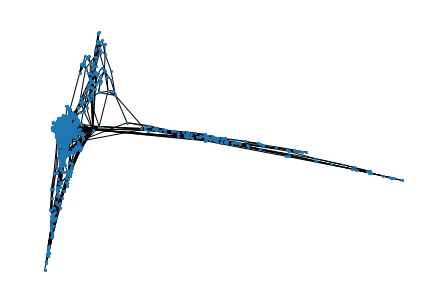

In [233]:
g = deepcopy(obs)
nx.draw_spectral(g, node_size=5)

Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvat

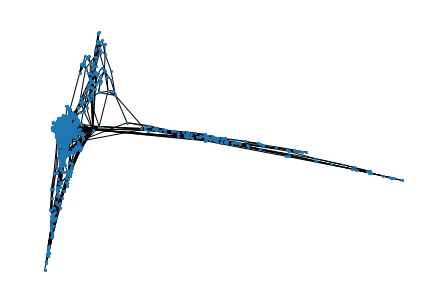

In [234]:
curva = sdrf_step(g)
nx.draw_spectral(curva.G, node_size=5)

Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvat

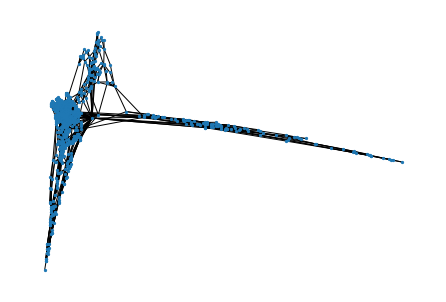

In [235]:
curva = sdrf_step(g)
nx.draw_spectral(curva.G, node_size=5)

Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvat

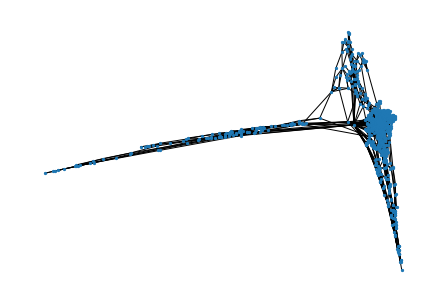

In [236]:
curva = sdrf_step(g)
nx.draw_spectral(curva.G, node_size=5)

Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvat

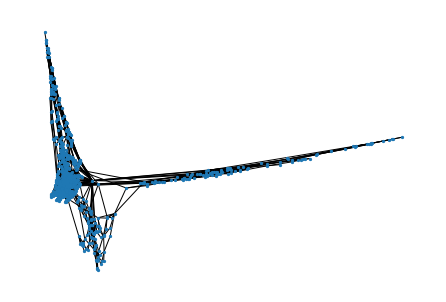

In [237]:
curva = sdrf_step(g)
nx.draw_spectral(curva.G, node_size=5)

Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvat

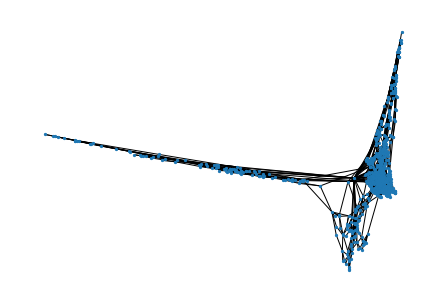

In [238]:
curva = sdrf_step(g)
nx.draw_spectral(curva.G, node_size=5)

In [49]:
# curva = OllivierRicci(obs, alpha=0.5, verbose="TRACE")
# obs = curva.compute_ricci_curvature()
# ricci_curvatures = nx.get_edge_attributes(obs, 'ricciCurvature').values()
# ricci_curvatures

In [50]:
# curva = FormanRicci(obs, verbose="TRACE")
# obs = curva.compute_ricci_curvature()
# ricci_curvatures = nx.get_edge_attributes(obs, 'ricciCurvature').values()
# ricci_curvatures

# frc = FormanRicci(g)
# frc.compute(ricci_curvature())

## (Refactor)Homophilly Index

In [51]:
def homophily_index(graph, key='class'):
    def f(node):
        ret = 0.
        ns = nx.all_neighbors(graph, node)
        for n in ns:
            if graph.nodes[node][key] == graph.nodes[n][key]:
                ret += 1
                
        return ret
    
    h = 0.
    for i in graph.nodes:
        d = graph.degree[i]
        n = f(i)
        h += (n / d)
        
    h = h / len(graph.nodes)
    
    return h

In [52]:
def barabasi(n=10, e=5):
    tmp = nx.generators.barabasi_albert_graph(n, e)
    labels = np.random.randint(0, 5, len(tmp.nodes))
    for i, j in enumerate(labels):
        tmp.nodes[i]['class'] = j
        
    return tmp

In [53]:
# draw kwargs
dk = {'node_size': 50}

In [54]:
tmp = barabasi()

In [55]:
classes = np.random.randint(0, 5, len(tmp))

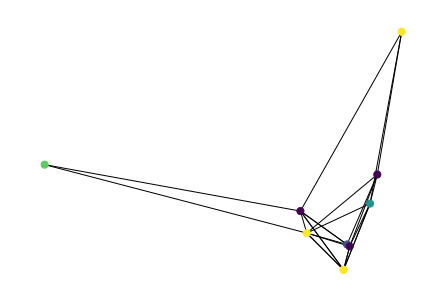

In [56]:
nx.draw_spectral(tmp, node_color=classes, **dk)

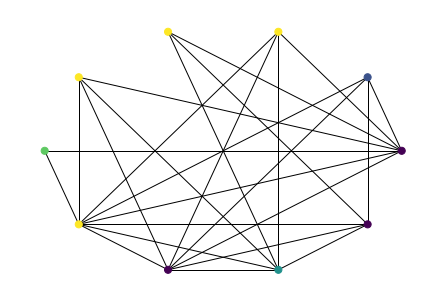

In [57]:
nx.draw(tmp, nx.circular_layout(tmp), node_color=classes, **dk)

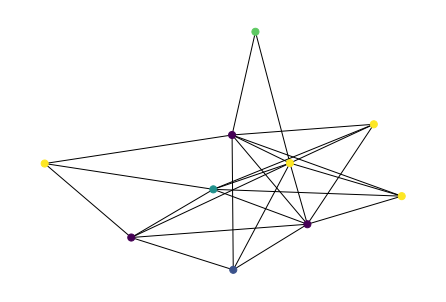

In [58]:
nx.draw(tmp, nx.spring_layout(tmp), node_color=classes, **dk)

In [59]:
barabasi(500, 50)
homophily_index(tmp)

0.16678571428571426

In [60]:
def label_pyg_from_dataset(ds):
    g = pyg.utils.to_networkx(ds[0])
    ys = ds[0].y.numpy()
    for n, y in zip(g.nodes, ys):
        g.nodes[n]['class'] = y
    return g

In [61]:
ds = pyg.datasets.CoraFull('/home/anthony/graph-datasets')
g = label_pyg_from_dataset(ds)
homophily_index(g)

0.5860540811502576

In [62]:
ds = pyg.datasets.Planetoid(root='tmp/Cora', name='Cora')
g = label_pyg_from_dataset(ds)
homophily_index(g)

0.8251578275927919

## Autoencoder

In [14]:
pyg_graphs = load_pyg()

In [106]:
pyg_graphs[0].edge_attr.max()

tensor(138)

In [107]:
pyg_graphs[0].edge_index.shape

torch.Size([2, 223991])

In [108]:
pyg_graphs[0].edge_attr.shape

torch.Size([223991, 2])

In [15]:
device = 'cuda:0'

In [16]:
class NodeEncoder(nn.Module):
    def __init__(self, text_dim, type_dim=3):
        super(NodeEncoder, self).__init__()
        # must add 1 for OOV
        text_dim += 1
        self.text_embedding = nn.Embedding(text_dim, 128)
        self.type_embedding = nn.Embedding(type_dim, 3)
        self.node_dim = \
            self.text_embedding.embedding_dim + self.type_embedding.embedding_dim

    def forward(self, x) -> torch.Tensor:
        text, type_ = x[..., 0], x[..., 1]

        text = text.long()
        text = self.text_embedding(text)

        type_ = type_.long()
        type_ = self.type_embedding(type_)

        x = torch.cat([text, type_], axis=-1)

        return x


class PositionEmbedding(nn.Module):
    def __init__(self, bin=128.0, pos_max=4096):
        # $e_pos$ : max of position
        # https://github.com/ChrisCummins/phd/blob/aab7f16bd1f3546f81e349fc6e2325fb17beb851/programl/models/ggnn/messaging_layer.py#L38
        super().__init__()
        self.pos_max = pos_max
        rg = torch.arange(0.0, pos_max, bin, dtype=float)
        inv_freq = 1 / (10000 ** (rg / pos_max))
        self.inv_freq = inv_freq  # .cuda()

    def forward(self, positions, dpad: int = 0):
        """Transformer-like sinusoidal positional embeddings.

        Args:
          positions: 1d long Tensor of positions.
          dpad: Padding zeros to concatenate to embedding vectors.
        """
        # inv_freq = self.inv_freq.unsqueeze(0).repeat(
        #     positions.shape[0], 1, 1
        # )
        self.inv_freq = self.inv_freq.to(positions.device)  # TODO: maybe bottlenectk

        sinusoid_inp = torch.outer(positions, self.inv_freq)
        pos_emb = torch.cat(
            (torch.sin(sinusoid_inp), torch.cos(sinusoid_inp)),
            dim=1
        )

        if dpad > 0:
            in_length = positions.size()[0]
            pad = torch.zeros((in_length, dpad))
            pos_emb = torch.cat([pos_emb, pad], dim=1)
            assert torch.all(
                pos_emb[:, -1] == torch.zeros(in_length)
            ), f"test failed. pos_emb: \n{pos_emb}"
        
        return pos_emb.float()


class EdgeEncoder(nn.Module):
    def __init__(self, bin=128.0, flow_dim=3):
        super(EdgeEncoder, self).__init__()

        self.flow_embedding = nn.Embedding(flow_dim, 3)
        self.pos_embedding = PositionEmbedding(bin=bin)
        self.edge_dim = \
            self.flow_embedding.embedding_dim + \
            self.pos_embedding.inv_freq.shape[0]

    def forward(self, x) -> torch.Tensor:
        flow, pos = x[..., 0], x[..., 1]

        flow = flow.long()
        flow = self.flow_embedding(flow)

        pos = pos.long()
        pos = self.pos_embedding(pos)

        x = torch.cat([flow, pos], axis=-1)

        return x


class Topology1st(nn.Module):
    def __init__(self, node_dim=131, edge_dim=67):
        super().__init__()
        self.c1 = pygnn.GATv2Conv(node_dim, 32, edge_dim=edge_dim)
        self.p1 = pygnn.TopKPooling(32, ratio=0.6)
        self.c2 = pygnn.GATv2Conv(32, 16, edge_dim=edge_dim)
        self.p2 = pygnn.TopKPooling(16, ratio=0.6)

    def forward(self, x, edge_index, edge_attr):
        x = self.c1(x, edge_index, edge_attr)
        x, edge_index, edge_attr, batch, perm, score = self.p1(
            x,
            edge_index,
            edge_attr
        )
        x = self.c2(x, edge_index, edge_attr)
        x, edge_index, edge_attr, batch, perm, score = self.p2(
            x,
            edge_index,
            edge_attr
        )

        return x

In [17]:
transform = T.Compose([
    T.RandomLinkSplit(
        num_val=0.05, num_test=0.1, is_undirected=False,
        split_labels=True, # must be true
        add_negative_train_samples=False
    ),
    T.ToDevice(device),
])
loader = pyg.loader.DataLoader(pyg_graphs)

In [121]:
pyg_graphs[0].x.shape

torch.Size([127169, 2])

In [263]:
pyg_graphs[0].x.dtype

torch.int64

In [ ]:
pyg_graphs[0].x.dtype

In [ ]:
# loader = pyg.loader.DataLoader(pyg_graphs)

In [18]:
ne = NodeEncoder(len(vocab))
ee = EdgeEncoder()
edge_dim = 67
class GCNEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.node_encoder = ne
        self.edge_encoder = ee
        
        # self.conv1 = pygnn.GATConv(in_channels, 2 * out_channels, edge_dim=edge_dim)
        # self.conv2 = pygnn.GATConv(2 * out_channels, out_channels, edge_dim=edge_dim)
        # self.conv1 = pygnn.GeneralConv(in_channels, 2 * out_channels, in_edge_channels=edge_dim)
        # self.conv2 = pygnn.GeneralConv(2 * out_channels, out_channels, in_edge_channels=edge_dim)
        # edge_dim = self.ee.edge_dim
        self.c1 = pygnn.GATv2Conv(-1, 32, edge_dim=edge_dim)
        # self.p1 = pygnn.TopKPooling(32, ratio=0.6)
        self.c2 = pygnn.GATv2Conv(32, 16, edge_dim=edge_dim)
        # self.p2 = pygnn.TopKPooling(16, ratio=0.6)
        
    def forward(self, x, edge_index, edge_attr):
        x = x.float()
        edge_index = edge_index.long()
        edge_attr = edge_attr.float()

        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr)
        
#         x = x.float()
#         edge_attr = edge_attr.float()
        
#         x = self.conv1(x, edge_index.to(device), edge_attr).relu()
#         x = self.conv2(x, edge_index.to(device), edge_attr)
        print(x.dtype, edge_index.dtype, edge_attr.dtype)
        x = self.c1(x, edge_index, edge_attr)
        # x, edge_index, edge_attr, batch, perm, score = self.p1(
        #     x,
        #     edge_index,
        #     edge_attr
        # )
        x = self.c2(x, edge_index, edge_attr)
        # x, edge_index, edge_attr, batch, perm, score = self.p2(
        #     x,
        #     edge_index,
        #     edge_attr
        # )
        # x = x.mean(-1)
        # edge_attr = edge_attr.mean(-1)

        # x = torch.cat([x.flatten(), edge_attr.flatten()])
        
        return x
    
class GCNDecoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # self.node_encoder = NodeEncoder(text_dim=len(vocab))
        # self.edge_encoder = EdgeEncoder()
        
        # self.conv1 = pygnn.GATConv(in_channels, 2 * out_channels, edge_dim=edge_dim)
        # self.conv2 = pygnn.GATConv(2 * out_channels, out_channels, edge_dim=edge_dim)
        # self.conv1 = pygnn.GeneralConv(in_channels, 2 * out_channels, in_edge_channels=edge_dim)
        # self.conv2 = pygnn.GeneralConv(2 * out_channels, out_channels, in_edge_channels=edge_dim)
        # edge_dim = self.edge_encoder.edge_dim
        self.c1 = pygnn.GATv2Conv(-1, 16)
        self.c2 = pygnn.GATv2Conv(16, 32)
        # self.p1 = pygnn.TopKPooling(32, ratio=0.6)

        # self.p2 = pygnn.TopKPooling(16, ratio=0.6)
        
    def forward(self, x, edge_index, *args, **kwargs):
        x = self.c1(x, edge_index)
        x = self.c2(x, edge_index)
        # x = x.mean(-1)
        # edge_attr = edge_attr.mean(-1)
        # x = torch.cat([x.flatten(), edge_attr.flatten()])
        
        return x

    
def train(data):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index, data.edge_attr)
    loss = model.recon_loss(z, data.pos_edge_label_index)
    if variational:
        loss = loss + (1 / train_data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index, data.edge_attr)
    return model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)

variational = True
model = pygnn.GAE(GCNEncoder())
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for graph in pyg_graphs:
    train_subgraph, val_subgraph, test_subgraph = transform(graph)
    print(train_subgraph)
    for epoch in range(1, epochs + 1):
        loss = train(train_subgraph)
        auc, ap = test(test_subgraph)
        print(f'Epoch: {epoch:03d}, AUC: {auc:.4f}, AP: {ap:.4f}')

Data(edge_index=[2, 190393], label=[127169], id=[223991], x=[127169, 2], edge_attr=[190393, 2], pos_edge_label=[190393], pos_edge_label_index=[2, 190393])
torch.float32 torch.int64 torch.float32


NameError: name 'train_data' is not defined

In [251]:
variational = False

In [252]:
# del model

In [241]:
# torch.cuda.empty_cache()

In [242]:
train_subgraph.x.shape

torch.Size([127169, 2])

In [243]:
print(train_subgraph.edge_index.shape)

torch.Size([2, 190393])


In [244]:
print(train_subgraph.edge_attr.shape)

torch.Size([190393, 2])


In [254]:
len(vocab)

7695

In [ ]:
len(env.inst2vec.vocab)

In [ ]:
env.inst2vec.unknown_vocab_element

In [ ]:
list(env.inst2vec.vocab.items())[100:102]

In [ ]:
# edges are indentical? 
edge_attrs = list(map(obs.edges.get, obs.edges))
for i in edge_attrs:
    assert {'flow', 'position'} == i.keys()
    
# edges have same type, 0?
for i in obs.edges:
    assert i[2] == 0

# Leaderboard
```
LLVM is a popular open source compiler used widely in industry and research.
The :code:`llvm-ic-v0` environment exposes LLVM's optimizing passes as a set of
actions that can be applied to a particular program. The goal of the agent is to
select the sequence of optimizations that lead to the greatest reduction in
instruction count in the program being compiled. Reward is the reduction in
instruction count achieved scaled to the reduction achieved by LLVM's builtin
:code:`-Oz` pipeline.


+--------------------+------------------------------------------------------+
| Property           | Value                                                |
+====================+======================================================+
| Environment        | :class:`LlvmEnv <compiler_gym.envs.LlvmEnv>`.        |
+--------------------+------------------------------------------------------+
| Observation Space  | Any.                                                 |
+--------------------+------------------------------------------------------+
| Reward Space       | Instruction count reduction relative to :code:`-Oz`. |
+--------------------+------------------------------------------------------+
| Test Dataset       | The 23 cBench benchmarks.                            |
+--------------------+------------------------------------------------------+
```

In [ ]:
from ray.rllib.agents.ppo import DEFAULT_CONFIG, PPOTrainer

In [ ]:
DEFAULT_CONFIG

In [ ]:
shared_encoder = tgnn.Sequential(
    'x, edge_index',
    [
        (tgnn.SuperGATConv(in_dim, 64), 'x, edge_index -> x'),
        nn.Tanh(),
        (tgnn.SuperGATConv(64, 64), 'x, edge_index -> x'),
    ]
)

num_outputs = ?
model_config = {}
name = ''

class GNN(TorchModelV2, nn.Module):
    def __init__(self):
        super().__init__(
            env.observation_space,
            env.action_space,
            num_outputs,
            model_config,
            name,
        )
        self.shared_encoder = shared_encoder
        self.action_model = nn.LazyLinear(action_n)
        self.value_model = nn.LazyLinear(1)

    def forward(self, input_dict):
        self.feature = self.shared_encoder(input_dict['obs'])
        x = self.action_layer(self.feature)
        return x, []
    
    def value_function(self):
        x = self.value_model(self.feature)
        return torch.reshape(x, [-1])

# Archived Codes

In [93]:
    env = compiler_gym.make(                
        "llvm-v0",                          
        benchmark="cbench-v1/qsort",        
        observation_space="Programl",       
        reward_space="IrInstructionCountOz",
    )

In [94]:
obs = env.reset()

In [96]:
obs.number_of_nodes()

1351

In [97]:
obs.number_of_edges()

2380

In [98]:
env.action_space.n

124

In [ ]:
def rollout(n=10000, record=False):
    buf = []
    env = compiler_gym.make(                
        "llvm-v0",                          
        benchmark="cbench-v1/qsort",        
        observation_space="Programl",       
        reward_space="IrInstructionCountOz",
    )
    obs = env.reset(benchmark="benchmark://cbench-v1/qsort")

    for i in range(n):
        ac = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        buf.append(obs)
        if done:
            obs = env.reset(benchmark="benchmark://cbench-v1/qsort")
            buf.append(obs)
            
    return buf

In [ ]:
class NodeEmbeddings(nn.Module):
    """Construct node embeddings (content embeddings + selector embeddings)
    Args:
    pretrained_embeddings (Tensor, optional) – FloatTensor containing weights for
    the Embedding. First dimension is being passed to Embedding as
    num_embeddings, second as embedding_dim.

    Forward
    Args:
    vocab_ids: <N, 1>
    selector_ids: <N, 1>
    Returns:
    node_states: <N, config.hidden_size>
    """

    # TODO(github.com/ChrisCummins/ProGraML/issues/27):: Maybe LayerNorm and
    # Dropout on node_embeddings?
    #
    # TODO(github.com/ChrisCummins/ProGraML/issues/27):: Make selector embeddings
    # trainable?
    #
    # TODO(github.com/ChrisCummins/ml4pl/issues/12): In the future we may want
    # to be more flexible in supporting multiple types of embeddings tables, but
    # for now I have hardcoded this to always return a tuple
    # <node_embeddings, selector_embeddings>, where inst2vec_embeddings
    # is the augmented table of pre-trained statement embeddings (the
    # augmentation adds !MAGIC, !IMMEDIATE, and !IDENTIFIER vocabulary
    # elements). selector_embeddings is a 2x2 1-hot embedding table:
    # [[1, 0], [0, 1]. The selector_embeddings table is always constant, the
    # inst2vec_embeddings table can be made trainable or re-initialized with
    # random values using the --inst2vec_embeddings flag.

    def __init__(
        self,
        node_embeddings_type: str,
        use_selector_embeddings: bool,
        selector_embedding_value: float = 50,
        embedding_shape: Optional[Tuple[int, int]] = None,
        pretrained_embeddings: Optional[np.array] = None,
    ):
    super().__init__()

    if node_embeddings_type == "pretrained":
        assert embedding_shape is None
        assert pretrained_embeddings is not None
        self._node_embeddings = nn.Embedding.from_pretrained(
        pretrained_embeddings, freeze=True
    )
    elif node_embeddings_type == "finetune":
        assert embedding_shape is None
        assert pretrained_embeddings is not None
        self._node_embeddings = nn.Embedding.from_pretrained(
        pretrained_embeddings, freeze=False
    )
    elif node_embeddings_type == "constant_zero":
        assert embedding_shape is not None
        assert pretrained_embeddings is None
        init = torch.zeros(*embedding_shape)
        self._node_embeddings = nn.Embedding.from_pretrained(init, freeze=True)
        assert embedding_shape is not None
        assert pretrained_embeddings is None
        init = torch.rand(*embedding_shape)
        self._node_embeddings = nn.Embedding.from_pretrained(init, freeze=True)
    elif node_embeddings_type == "random":
        assert embedding_shape is not None
        assert pretrained_embeddings is None
        self._node_embeddings = nn.Embedding(*embedding_shape)
    else:
        raise ValueError(
            f"Unsupported node embeddings type: {node_embeddings_type}"
        )

    if use_selector_embeddings:
        # The selector embeddings table is a 1-hot encoded table for <true,false>
        # binary selector values.
        selector_init = torch.tensor(
            [[selector_embedding_value, 0], [0, selector_embedding_value]],
            dtype=torch.get_default_dtype(),
        )
        self._selector_embeddings = nn.Embedding.from_pretrained(
            selector_init, freeze=True
        )
    else:
        self._selector_embeddings = None

        self.vocab_size = embedding_shape[0]
        self.text_embedding_dimensionality = embedding_shape[1]
        self.selector_embedding_dimensionality = (
            2 if self._selector_embeddings else 0
        )
        self.embedding_dimensionality = (
          self.text_embedding_dimensionality
          + self.selector_embedding_dimensionality
        )

    def forward(self, vocab_ids, selector_ids=None):
        embeddings = self._node_embeddings(vocab_ids)
        if self._selector_embeddings:
            selector_embeddings = self._selector_embeddings(selector_ids)
            embeddings = torch.cat((embeddings, selector_embeddings), dim=1)
        return embeddings

In [ ]:
import random
import statistics
from collections import namedtuple
from typing import List

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from absl import app, flags
from torch.distributions import Categorical

import compiler_gym.util.flags.episodes  # noqa Flag definition.
import compiler_gym.util.flags.learning_rate  # noqa Flag definition.
import compiler_gym.util.flags.seed  # noqa Flag definition.
from compiler_gym.util.flags.benchmark_from_flags import benchmark_from_flags
from compiler_gym.util.flags.env_from_flags import env_from_flags
from compiler_gym.wrappers import ConstrainedCommandline, TimeLimit

flags.DEFINE_list(
    "flags",
    [
        "-break-crit-edges",
        "-early-cse-memssa",
        "-gvn-hoist",
        "-gvn",
        "-instcombine",
        "-instsimplify",
        "-jump-threading",
        "-loop-reduce",
        "-loop-rotate",
        "-loop-versioning",
        "-mem2reg",
        "-newgvn",
        "-reg2mem",
        "-simplifycfg",
        "-sroa",
    ],
    "List of optimizatins to explore.",
)
flags.DEFINE_integer("episode_len", 5, "Number of transitions per episode.")
flags.DEFINE_integer("hidden_size", 64, "Latent vector size.")
flags.DEFINE_integer("log_interval", 100, "Episodes per log output.")
flags.DEFINE_integer("iterations", 1, "Times to redo entire training.")
flags.DEFINE_float("exploration", 0.0, "Rate to explore random transitions.")
flags.DEFINE_float("mean_smoothing", 0.95, "Smoothing factor for mean normalization.")
flags.DEFINE_float("std_smoothing", 0.4, "Smoothing factor for std dev normalization.")


In [ ]:

eps = np.finfo(np.float32).eps.item()

SavedAction = namedtuple("SavedAction", ["log_prob", "value"])

FLAGS = flags.FLAGS


class MovingExponentialAverage:
    """Simple class to calculate exponential moving averages."""

    def __init__(self, smoothing_factor):
        self.smoothing_factor = smoothing_factor
        self.value = None

    def next(self, entry):
        assert entry is not None
        if self.value is None:
            self.value = entry
        else:
            self.value = (
                entry * (1 - self.smoothing_factor) + self.value * self.smoothing_factor
            )
        return self.value


class HistoryObservation(gym.ObservationWrapper):
    """For the input representation (state), if there are N possible
    actions, then an action x is represented by a one-hot vector V(x)
    with N entries. A sequence of M actions (x, y, ...) is represented
    by an MxN matrix of 1-hot vectors (V(x), V(y), ...). Actions that
    have not been taken yet are represented as the zero vector. This
    way the input does not have a variable size since each episode has
    a fixed number of actions.
    """

    def __init__(self, env):
        super().__init__(env=env)
        self.observation_space = gym.spaces.Box(
            low=np.full(len(FLAGS.flags), 0, dtype=np.float32),
            high=np.full(len(FLAGS.flags), float("inf"), dtype=np.float32),
            dtype=np.float32,
        )

    def reset(self, *args, **kwargs):
        self._steps_taken = 0
        self._state = np.zeros(
            (FLAGS.episode_len - 1, self.action_space.n), dtype=np.int32
        )
        return super().reset(*args, **kwargs)

    def step(self, action: int):
        assert self._steps_taken < FLAGS.episode_len
        if self._steps_taken < FLAGS.episode_len - 1:
            # Don't need to record the last action since there are no
            # further decisions to be made at that point, so that
            # information need never be presented to the model.
            self._state[self._steps_taken][action] = 1
        self._steps_taken += 1

        return super().step(action)

    def observation(self, observation):
        return self._state


class Policy(nn.Module):
    """A very simple actor critic policy model."""

    def __init__(self):
        super().__init__()
        self.affine1 = nn.Linear(
            (FLAGS.episode_len - 1) * len(FLAGS.flags), FLAGS.hidden_size
        )
        self.affine2 = nn.Linear(FLAGS.hidden_size, FLAGS.hidden_size)
        self.affine3 = nn.Linear(FLAGS.hidden_size, FLAGS.hidden_size)
        self.affine4 = nn.Linear(FLAGS.hidden_size, FLAGS.hidden_size)

        # Actor's layer
        self.action_head = nn.Linear(FLAGS.hidden_size, len(FLAGS.flags))

        # Critic's layer
        self.value_head = nn.Linear(FLAGS.hidden_size, 1)

        # Action & reward buffer
        self.saved_actions: List[SavedAction] = []
        self.rewards: List[float] = []

        # Keep exponential moving average of mean and standard
        # deviation for use in normalization of the input.
        self.moving_mean = MovingExponentialAverage(FLAGS.mean_smoothing)
        self.moving_std = MovingExponentialAverage(FLAGS.std_smoothing)

    def forward(self, x):
        """Forward of both actor and critic"""
        # Initial layer maps the sequence of one-hot vectors into a
        # vector of the hidden size. Next layers stay with the same
        # size and use residual connections.
        x = F.relu(self.affine1(x))
        x = x.add(F.relu(self.affine2(x)))
        x = x.add(F.relu(self.affine3(x)))
        x = x.add(F.relu(self.affine4(x)))

        # actor: choses action to take from state s_t
        # by returning probability of each action
        action_prob = F.softmax(self.action_head(x), dim=-1)

        # critic: evaluates being in the state s_t
        state_values = self.value_head(x)

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t
        return action_prob, state_values


def select_action(model, state, exploration_rate=0.0):
    """Selects an action and registers it with the action buffer."""
    state = torch.from_numpy(state.flatten()).float()
    probs, state_value = model(state)

    # Create a probability distribution where the probability of
    # action i is probs[i].
    m = Categorical(probs)

    # Sample an action using the distribution, or pick an action
    # uniformly at random if in an exploration mode.
    if random.random() < exploration_rate:
        action = torch.tensor(random.randrange(0, len(probs)))
    else:
        action = m.sample()

    # Save to action buffer. The drawing of a sample above simply
    # returns a constant integer that we cannot back-propagate
    # through, so it is important here that log_prob() is symbolic.
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))

    # The action to take.
    return action.item()


def finish_episode(model, optimizer) -> float:
    """The training code. Calculates actor and critic loss and performs backprop."""
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []  # list to save actor (policy) loss
    value_losses = []  # list to save critic (value) loss
    returns = []  # list to save the true values

    # Calculate the true value using rewards returned from the
    # environment. We are iterating in reverse order while inserting
    # at each step to the front of the returns list, which implies
    # that returns[i] is the sum of rewards[j] for j >= i. We do not
    # use a discount factor as the episode length is fixed and not
    # very long, but if we had used one, it would appear here.
    for r in model.rewards[::-1]:
        R += r
        returns.insert(0, R)

    # Update the moving averages for mean and standard deviation and
    # use that to normalize the input.
    returns = torch.tensor(returns)
    model.moving_mean.next(returns.mean())
    model.moving_std.next(returns.std())
    returns = (returns - model.moving_mean.value) / (model.moving_std.value + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        # The advantage is how much better a situation turned out in
        # this case than the critic expected it to.
        advantage = R - value.item()

        # Calculate the actor (policy) loss. Because log_prob is
        # symbolic, back propagation will increase the probability of
        # taking the action that was taken if advantage is positive
        # and will decrease it if advantage is negative. In this way
        # we are learning a probability distribution without directly
        # being able to back propagate through the drawing of the
        # sample from that distribution.
        #
        # It may seem that once the critic becomes accurate, so that
        # the advantage is always 0, then the policy can no longer
        # learn because multiplication by 0 impedes back
        # propagation. However, the critic does not know which action
        # will be taken, so as long as there are worse-than-average or
        # better-than-average policies with a non-zero probability,
        # then the critic has to be wrong sometimes because it can
        # only make one prediction across all actions, so learning
        # will proceed.
        policy_losses.append(-log_prob * advantage)

        # Calculate critic (value) loss using L1 smooth loss.
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    # Reset gradients.
    optimizer.zero_grad()

    # Sum up all the values of policy_losses and value_losses.
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    loss_value = loss.item()

    # Perform backprop.
    loss.backward()
    optimizer.step()

    # Reset rewards and action buffer.
    del model.rewards[:]
    del model.saved_actions[:]

    return loss_value


def TrainActorCritic(env):
    model = Policy()
    optimizer = optim.Adam(model.parameters(), lr=FLAGS.learning_rate)

    # These statistics are just for logging.
    max_ep_reward = -float("inf")
    avg_reward = MovingExponentialAverage(0.95)
    avg_loss = MovingExponentialAverage(0.95)

    for episode in range(1, FLAGS.episodes + 1):
        # Reset environment and episode reward.
        state = env.reset()
        ep_reward = 0

        # The environment keeps track of when the episode is done, so
        # we can loop infinitely here.
        while True:
            # Select action from policy.
            action = select_action(model, state, FLAGS.exploration)

            # Take the action
            state, reward, done, _ = env.step(action)

            model.rewards.append(reward)
            ep_reward += reward
            if done:
                break

        # Perform back propagation.
        loss = finish_episode(model, optimizer)

        # Update statistics.
        max_ep_reward = max(max_ep_reward, ep_reward)
        avg_reward.next(ep_reward)
        avg_loss.next(loss)

        # Log statistics.
        if (
            episode == 1
            or episode % FLAGS.log_interval == 0
            or episode == FLAGS.episodes
        ):
            print(
                f"Episode {episode}\t"
                f"Last reward: {ep_reward:.2f}\t"
                f"Avg reward: {avg_reward.value:.2f}\t"
                f"Best reward: {max_ep_reward:.2f}\t"
                f"Last loss: {loss:.6f}\t"
                f"Avg loss: {avg_loss.value:.6f}\t",
                flush=True,
            )

    print(f"\nFinal performance (avg reward): {avg_reward.value:.2f}")
    print(f"Final avg reward versus own best: {avg_reward.value - max_ep_reward:.2f}")

    # One could also return the best found solution here, though that
    # is more random and noisy, while the average reward indicates how
    # well the model is working on a consistent basis.
    return avg_reward.value


def make_env():
    FLAGS.env = "llvm-v0"
    if not FLAGS.reward:
        FLAGS.reward = "IrInstructionCountOz"
    env = env_from_flags(benchmark=benchmark_from_flags())
    env = ConstrainedCommandline(env, flags=FLAGS.flags)
    env = TimeLimit(env, max_episode_steps=FLAGS.episode_len)
    env = HistoryObservation(env)
    return env


def main():
    """Main entry point."""
#     del argv  # unused

    torch.manual_seed(FLAGS.seed)
    random.seed(FLAGS.seed)

    with make_env() as env:
        print(f"Seed: {FLAGS.seed}")
        print(f"Episode length: {FLAGS.episode_len}")
        print(f"Exploration: {FLAGS.exploration:.2%}")
        print(f"Learning rate: {FLAGS.learning_rate}")
        print(f"Reward: {FLAGS.reward}")
        print(f"Benchmark: {FLAGS.benchmark}")
        print(f"Action space: {env.action_space}")

        if FLAGS.iterations == 1:
            TrainActorCritic(env)
            return

        # Performance varies greatly with random initialization and
        # other random choices, so run the process multiple times to
        # determine the distribution of outcomes.
        performances = []
        for i in range(1, FLAGS.iterations + 1):
            print(f"\n*** Iteration {i} of {FLAGS.iterations}")
            performances.append(TrainActorCritic(env))

        print("\n*** Summary")
        print(f"Final performances: {performances}\n")
        print(f"  Best performance: {max(performances):.2f}")
        print(f"Median performance: {statistics.median(performances):.2f}")
        print(f"   Avg performance: {statistics.mean(performances):.2f}")
        print(f" Worst performance: {min(performances):.2f}")